# Feature Engineering

> People come to me as a data scientist with their data. 
> Then my job becomes part data-hazmat officer, part grief 
> counselor.<br/>–Anonymous

Chapter 6 (*Value Imputation*) looked at filling in missing values.  In chapter 5 (*Data Quality*) we touched on normalization and scaling which adjust values to artificially fit certain numeric or categorical patterns.  Both of those earlier topics come close to the subject of this chapter, but here we focus more directly on the creation of *synthetic features* based on raw data sets.  Whereas imputation is a matter of making reasonable guesses about what missing values might be, feature engineering is about changing the *representational form* of data, but in ways that are deterministic and often information preserving (e.g. reversible). A simple example of a synthetic feature is the construction of BMI (body mass index) in the prior chapter.

There are many ways we might transform data.  In a simple case, we might transform a numeric or string representation of a datetime into a native representation that makes many operations easier.  For strings, we might produce canonical representations and/or treat them as categories (also called factors).  Moreover, a single string can often contain several meaningful but independent pieces of information that are more usefully treated as separate variables.  For numeric values, at times transforming them into distinct ranges, and hence into ordinal values, can sometimes help reveal a pattern that is muddied by too much precision.  Of course, quantization is not among the reversible transformations; but good practice continues to recommend versioning data and scripting transformations for repeatability.

While data type changes in the representation of individual features is important, we also sometimes wish to perform something more systematic with the parameter space and dimensionality of our data set.  One-hot encoding is a simple transformation that turns a single categorical feature into multiple numeric fields; this is often needed for specific statistical or modeling techniques. Polynomial features are synthetic features which combine multiple raw features in a manner that can often reveal meaningful interactions that cannot be seen in univariate features.

A completely systematic transformation is performed in a decomposition.  Principal component analysis and other techniques transform the entire parameter space in an information preserving way.  In itself, such a transformation does not gain or lose any information, but this is often coupled with *dimensionality reduction* where the bulk of the information can be gleaned from only a subset of these transformed dimensions.  Depending on your purpose, such a transformation may make models more tractable and/or of better quality.

---

Before we get to the sections of this chapter, let us run our standard setup code.

In [1]:
from src.setup import *
%load_ext rpy2.ipython

In [2]:
%%capture --no-stdout err
%%R 
library(tidyverse)

This chapter uses capabilities within scikit-learn more extensively than do other chapters.  Everything that I demonstrate here using scikit-learn can certainly be accomplished in other ways as well.  It just happens that scikit-learn builds in a great many of the tools one wants for feature engineering, in preparing data for a machine learning model.  The APIs provided by scikit-learn are consistent and well-designed, so it certainly merits praise, in general, but the goal of this chapter is to explain underlying concepts. 

## Date/time fields

> Time is a game played beautifully by children.<br/>
> –Heraclitus

**Concepts**:

* Combining timestamp components
* Date/time operations in data frames
* Time deltas
* Duplicated timestamps (selection versus averaging)
* Resampling and grouping
* Interpolation at missing timestamps

As an example of date encoding that is not as immediately useful as we would like, let us return to the temperature readings that have been used elsewhere in the book.  For the different purpose elsewhere, we simply provided a `read_glarp()` function that performed a minor amount of data cleanup within the function.  For this section, we will do some similar operations from the raw data.

The temperature data consists of several files, each containing measurements for a different automated thermometer that (usually) takes a reading every three minutes.  Looking at one of those, we see the contents are arranged like this:

In [3]:
%%bash
zcat data/glarp/outside.gz | head -5

2003 07 25 16 04 27.500000
2003 07 25 16 07 27.300000
2003 07 25 16 10 27.300000
2003 07 25 16 13 27.400000
2003 07 25 16 16 27.800000


These files have no headers, but the several columns correspond to what you would intuitively parse as dates in 2003 and 2004.  We can read in the file as either space delimited or as fixed-width, equivalently, for this particular format. Here we read it with Pandas as a space delimited file.

In [4]:
temps = pd.read_csv('data/glarp/outside.gz', 
                    sep=' ', header=None, 
                    names=['year', 'month', 'day', 
                           'hour', 'minute', 'degrees'])
temps.head(5)

year  month  day  hour  minute  degrees
0  2003      7   25    16       4     27.5
1  2003      7   25    16       7     27.3
2  2003      7   25    16      10     27.3
3  2003      7   25    16      13     27.4
4  2003      7   25    16      16     27.8

The particular problems or issues in this outside temperatures data set are minor.  However, there remain enough of them that it will allow us to use many of the most common techniques that you will need in working with time series data in general.  The examples in this section all utilize Pandas, but other data frame libraries, in whatever language, will typically have similar capabilities.

### Creating Datetimes

All the information we want is available in the data frame, but let us make it more useful.  Many Pandas operations are especially convenient with DataTime indices, so we make that the index.

In [5]:
ts_fields = ['year', 'month', 'day', 'hour', 'minute']
temps.index = pd.to_datetime(temps[ts_fields])
temps.drop(columns=ts_fields, inplace=True)
temps

degrees
2003-07-25 16:04:00     27.5
2003-07-25 16:07:00     27.3
2003-07-25 16:10:00     27.3
2003-07-25 16:13:00     27.4
...                      ...
2004-07-16 15:19:00     16.9
2004-07-16 15:22:00     16.8
2004-07-16 15:25:00     16.8
2004-07-16 15:28:00     16.4

[169513 rows x 1 columns]

Even though this data seems to be in time series order from a superficial look, there are many rows and it may not always be.  Generally we would like to keep chronological data in order for many kinds of operations, including for producing graphs that might represent it.  We could simply order the time series (the index in this case) as an idempotent operation, but before we do that, let us check whether that goal is already met.

In [6]:
temps.index.is_monotonic_increasing

False

We can probe into this by looking at the step differences—expressed in Pandas as a `Timedelta`—between successive rows.

In [7]:
increments = temps.index.to_series().diff()
increments[increments < pd.Timedelta(minutes=0)]

2003-10-26 01:01:00   -1 days +23:03:00
dtype: timedelta64[ns]

The index is not monotonic, and there is one backward jump (it occurs one hour earlier than the actual Daylight Savings Time adjustment that year, but is presumably still related).  We should reflect on the fact that data that are ordered by some field values are not necessarily represented that way in their actual on-disk format.  Many formats, such as SQL databases, perform all sorts of optimizations that can ignore ordering assumptions unless imposed.  Before we look further, let us explicitly order the data by its `DateTimeIndex`.

In [8]:
temps.sort_index(inplace=True)
temps.index.is_monotonic_increasing

True

### Imposing Regularity

As you may have determined in an exercise in chapter 5 (*Data Quality*), there are missing timestamps where we would expect in the general "every three minutes" pattern.  Let us first verify that such gaps actually exist, then remediate them to produce a more regular time series.  What we do here is clearly related to value imputation; it differs in "inventing" entire rows rather than only individual data points. Recall that three minute increments over slightly less than a year adds up to about 170,000 expected observations.

In [9]:
increments = temps.index.to_series().diff()
gaps = increments[increments > pd.Timedelta(minutes=3)]
gaps

2003-07-26 19:28:00   0 days 00:06:00
2003-07-27 09:10:00   0 days 00:06:00
2003-07-29 08:28:00   0 days 00:06:00
2003-07-29 11:43:00   0 days 00:06:00
                            ...      
2004-07-05 19:55:00   0 days 07:36:00
2004-07-06 09:28:00   0 days 00:06:00
2004-07-06 16:28:00   0 days 00:06:00
2004-07-14 04:04:00   0 days 00:06:00
Length: 160, dtype: timedelta64[ns]

So indeed we have  some gaps in our measurements.  They are not all that numerous, only about one in a thousand measurements are adjacent to time increments more than three minutes apart.  We do, however, see that while most gaps are the loss of a single measurement—i.e. six minutes rather than then expected three—at some places larger gaps exist.  A few large gaps exist; the longest one is over a day.  Others are measured in hours or minutes.

In [10]:
with show_more_rows():
    print(gaps.sort_values(ascending=False).head(15))

2003-12-11 03:04:00   1 days 13:48:00
2004-04-28 00:31:00   0 days 13:06:00
2004-07-05 19:55:00   0 days 07:36:00
2003-12-18 09:25:00   0 days 06:33:00
2003-12-06 09:25:00   0 days 06:24:00
2003-12-29 08:46:00   0 days 06:03:00
2003-12-11 14:19:00   0 days 04:42:00
2004-04-04 03:01:00   0 days 01:03:00
2004-06-30 18:13:00   0 days 00:33:00
2003-11-24 08:04:00   0 days 00:30:00
2003-10-11 17:13:00   0 days 00:27:00
2003-12-13 17:10:00   0 days 00:15:00
2004-06-30 03:07:00   0 days 00:12:00
2004-06-22 10:16:00   0 days 00:12:00
2004-07-02 09:22:00   0 days 00:12:00
dtype: timedelta64[ns]


A typical small gap looks something like the example below.  An observation was missed at '2003-07-26 19:25:00' that we would generally expect to be present.  This is missing data, but by its implied absence relative to a predictable sequence rather than being explicitly marked with some sentinel.

In [11]:
temps.loc['2003-07-26 19:22:00':'2003-07-26 19:28:00']

degrees
2003-07-26 19:22:00     27.5
2003-07-26 19:28:00     27.1

We can also look for cases where the gap between measurements is too short.  There are few of them, but seeing those few will point to another problem.

In [12]:
small_steps = increments[increments < pd.Timedelta(minutes=3)]
small_steps.sort_values(ascending=False)

2003-10-03 12:04:00   0 days 00:02:00
2003-12-24 15:10:00   0 days 00:00:00
2003-10-26 01:01:00   0 days 00:00:00
2003-10-26 01:07:00   0 days 00:00:00
                            ...      
2003-10-26 01:52:00   0 days 00:00:00
2003-10-26 01:55:00   0 days 00:00:00
2003-10-26 01:58:00   0 days 00:00:00
2003-10-26 01:31:00   0 days 00:00:00
Length: 22, dtype: timedelta64[ns]

The number of small gaps in the time timestamps is only 22, but even more specifically, all of them except one are an actual zero time delta, which is to say duplicated datetime values.  The one gap that is 2 minutes rather than the expected three will make the spacing of observations slightly irregular since later points will be at a one minute offset from the expected position.  

As a domain judgement, we will decide that a one minute difference is not significant to any analysis or modeling we do on the data.  However, this is a judgement that we need to make, and will not be universal to every data set.  In particular, when we regularize relative to missing observations below, we will also shift the imputed times of measurement for many observations.  For events tied to specific times rather than patterns of change in the data, this shift would probably be unacceptable.

The next cell is also an opportunity to illustrate a nice feature of the Pandas API.  We will look at a slice of data surrounding the 2 minute gap, but the ends of the slice are times that do not actually occur in the data themselves.  Pandas is clever enough to know about chronological order, and choose all index values that are *between* particular datetimes, even if the ends are not themselves present.  We are also able to write datetimes as either actual datetime objects or as strings (in any of several guessed string formats; using ISO-8601 is always the best choice, where possible).

In [13]:
temps.loc['2003-10-03 11:57':'2003-10-03 12:08']

degrees
2003-10-03 11:58:00     13.0
2003-10-03 12:02:00     12.8
2003-10-03 12:04:00     12.8
2003-10-03 12:07:00     12.8

### Duplicated Timestamps

Here we encounter another problem that is not uncommon with time series data.  A small minority of rows in our data are indexed by identical timestamp.  We are fortunate in this data set that it is only 41 problem rows out of 170,000, so almost any approach here is probably fine.  Note that in many cases, additional columns may be part of the explicit or implicit key.  For example if the other location temperatures were aggregated with the outside temperatures, a tidy data frame could include the location as a categorical column; in that case, we would typically expect many duplicate timestamps, but only one per category/location.

In [14]:
# Show all rows that are part of duplicate set
# Other `keep` options will drop some or all duplicates
temps[temps.index.duplicated(keep=False)]

degrees
2003-10-26 01:01:00      1.9
2003-10-26 01:01:00      0.9
2003-10-26 01:07:00      1.9
2003-10-26 01:07:00      1.1
...                      ...
2003-10-26 01:58:00      0.1
2003-12-24 15:10:00      6.4
2003-12-24 15:10:00     20.9
2003-12-24 15:10:00      6.4

[41 rows x 1 columns]

Most duplicates have a small value difference, one degree Celsius or less.  However, something peculiar happens at '2003-12-24 15:10:00'.  There are three different values recorded at that same moment, two of them 6.4℃, but the remaining one is 20.9℃.  Both our domain knowledge of outdoor temperatures in Colorado in December, and the pattern of the data itself, would probably lead us to discard this clear outlier.  Quite likely, since several instruments were recording, most of them inside a heated house, this 20.9 reading is a transposition with a measurement of a different thermometer.

One option for us is to use Pandas' method `.drop_duplicates()`.  It gives us the option to keep the first row, keep the last row, or drop all rows with such ambiguity.  We do not have a clear basis to decide among those options, but none would be harmful in this case, given the comparative infrequency of the duplicates.  For example:

In [15]:
no_dups = (temps
             .reset_index()  # De-dup on named column
             .drop_duplicates(keep='first', subset='index')
             .set_index('index'))

print(f"Length of original DataFrame: {len(temps):,}")
print(f"Length of de-duped DataFrame: {len(no_dups):,}")

# Check if datetime index is now unique
no_dups.index.is_unique

Length of original DataFrame: 169,513
Length of de-duped DataFrame: 169,492


True

Another approach to de-duplication of duplicated timestamps is to group aggregate common values.  For example, if we are not sure which measurement is to be preferred, we could take the mean of the several values.  This is probably irrelevant for this specific data, and probably wrong for the case we noted with an obvious outlier among the duplicates.  But let us look at the API anyway:

In [16]:
mean_dups = temps.groupby(temps.index).mean()

print(f"Length of mean-by-duplicate: {len(mean_dups):,}")
mean_dups.index.is_unique

Length of mean-by-duplicate: 169,492


True

### Adding Timestamps

As we have noted, there are gaps in the time series data.  Most are single missing measurements on the expected three-minute schedule, but one is over a day, and several are numerous hours.  We also have the issue noted where one gap is two minutes long rather than three minutes, which we are aware of but will not treat as critical for the current data set.

The typical way of adding more datetime rows is to resample the data to a desired frequency.  For example, if we only wanted the temperature by month, but as a mean, we could do an operation like:

In [17]:
# See Pandas docs, it is easy to confuse M=month with m=minute
no_dups.resample('1M').mean()

degrees
index                
2003-07-31  21.508462
2003-08-31  20.945075
2003-09-30  14.179293
2003-10-31  12.544181
...               ...
2004-04-30   7.708277
2004-05-31  14.357831
2004-06-30  15.420425
2004-07-31  20.527493

[13 rows x 1 columns]

Intuitively, such a lower frequency resampling is very similar to grouping.  We can get the same effect using `.groupby()`.  Here we use slightly tricky code in that we want the months in chronological order rather than alphabetical; one way to get that is to include the number in the grouping, but then drop it.

In [18]:
# Groupby both month number and name
by_month = no_dups.groupby(
    [no_dups.index.month, no_dups.index.month_name()])
# The mean temperature over the month
by_month = by_month.mean()
# Discard the month number now that result is sorted
by_month = by_month.droplevel(0)
# Name the index
by_month.index.name = 'month_name'
by_month

degrees
month_name           
January      0.433968
February    -0.209109
March        7.848025
April        7.708277
...               ...
September   14.179293
October     12.544181
November     2.332037
December     0.667080

[12 rows x 1 columns]

We have done something a bit different here in that the average is over a named month rather than an actual chronological month.  It makes little difference in this example since our data ranges over almost exactly a year.  However, even here, we have averaged some numbers from July 2003 with some others from July 2004.  If that matters, we could include the year in the grouping as well to avoid that.  Of course, if we are looking for typical temperatures for a time of year, this may in fact be closer to our goal for multi-year data.

Although the starting point is different, September and October show identical means between the techniques (only July will be a little different).  However, downsampling to monthly data is really not our declared task.  Rather we with to upsample slightly to fill in the missing 3-minute increments.  This is just as easy.  Recall that we have started out with 169,513 observations before this conversion to a uniform 3-minute frequency.

In [19]:
filled_temps = no_dups.asfreq('3T')
filled_temps

degrees
index                       
2003-07-25 16:04:00     27.5
2003-07-25 16:07:00     27.3
2003-07-25 16:10:00     27.3
2003-07-25 16:13:00     27.4
...                      ...
2004-07-16 15:19:00     16.9
2004-07-16 15:22:00     16.8
2004-07-16 15:25:00     16.8
2004-07-16 15:28:00     16.4

[171349 rows x 1 columns]

The method `.asfreq()` has an optional argument to back-fill or forward-fill.  We have not used this, and therefore our data now contains a certain number of missing values (marked as NaN).  Chapter 6 (*Value Imputation*) discusses strategies for filling and interpolation that we might use to guess values for the missing data.  We can see how many missing values there are.

In [20]:
sum(filled_temps.degrees.isnull())

1858

For the places where we added a single missing timestamp, any kind of filling or interpolation is probably sufficient.  However, for the small number of larger gaps of multiple hours or even over a day, a linear interpolation almost surely does a poor job for the missing interval.

Remember the somewhat odd change in timestamp offset, where a single 2-minute increment occurred? One or more of the other gaps righted the minutes-after-hour by the end of the time series, but some of the middle resampled measurements are shifted from their strict measurement time.  One option here would be to *upsample* quite a bit to a one-minute frequency, and also combine that with a more sophisticated interpolation technique.  Pandas provides—mostly by way of **SciPy**, if it is installed—a rich collection of interpolations: nearest, zero, slinear, quadratic, cubic, spline, barycentric, polynomial, krogh, piecewise_polynomial, pchip, akima, from_derivatives.

One of these higher-order interpolations is likely to perform quite accurately on the few hour gaps, but obviously less well on the day length gap.  Let us upsample to one-minute frequency and then fill missing timestamps using spline interpolation.

In [21]:
one_minute_temps = no_dups.asfreq('1T')
one_minute_temps.index.name = 'Timestamp'
one_minute_temps

degrees
Timestamp                   
2003-07-25 16:04:00     27.5
2003-07-25 16:05:00      NaN
2003-07-25 16:06:00      NaN
2003-07-25 16:07:00     27.3
...                      ...
2004-07-16 15:25:00     16.8
2004-07-16 15:26:00      NaN
2004-07-16 15:27:00      NaN
2004-07-16 15:28:00     16.4

[514045 rows x 1 columns]

This high sampling frequency produces many rows and also many NaNs on the first pass.

In [22]:
one_minute_temps.interpolate(method='spline', order=3, 
                             inplace=True)
one_minute_temps.head()

degrees
Timestamp                     
2003-07-25 16:04:00  27.500000
2003-07-25 16:05:00  27.082346
2003-07-25 16:06:00  27.079049
2003-07-25 16:07:00  27.300000
2003-07-25 16:08:00  27.072395

All values are filled with some imputed value here, but it is particularly interesting to look at the region around the missing day and a half at 2003-12-11.

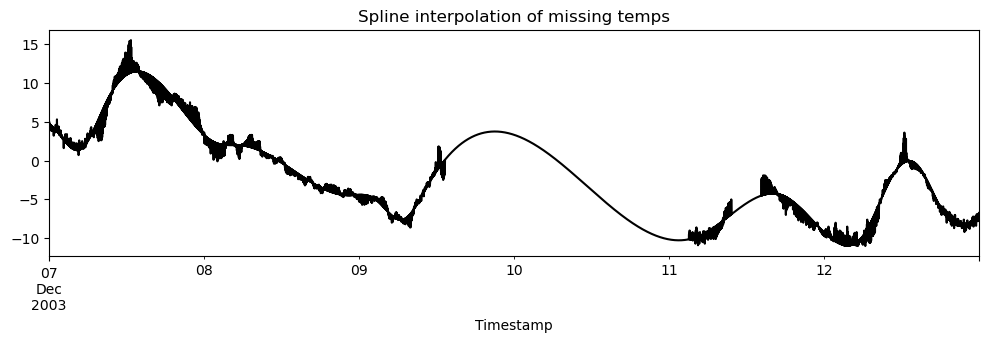

In [23]:
(one_minute_temps
     .loc['2003-12-07':'2003-12-12', 'degrees']
     .plot(title="Spline interpolation of missing temps", 
           figsize=(12,3)))
plt.savefig("img/(Ch07)Spline interpolation of missing temps.png")

It is easy to see where the smooth trend was interpolated/imputed versus the much messier raw data (even though 2/3 of the "raw" data is actually imputed, but very locally).  While the long gap around 2003-12-11 may not be accurate, it is not implausible and should not unduly affect models of the whole data set.  There is even a smaller few hour gap a few hours after the long gap that is clearly relatively close to what the missing data would have been.

Choosing the best interpolation technique is an art.  A great deal depends on what cyclicities we expect in the time series data, if any. Indeed, it depends as well on whether the order of the data is a time series at all, or if it is some other type of sequence.  The discussion in chapter 5 (*Data Quality*) of detrending data is relevant.  In the absence of domain knowledge that leads to an expectation of specific behavior, a simple linear interpolation of missing points limits the potential harm while not necessarily reaping much benefit.  Where the data *is* time series data, using time-sensitive regression makes sense; see chapter 6 (*Value Imputation*).  However, where you have an expectation of a more complex, but regular, pattern in the gaps, using an interpolation technique such as spline, polynomial, or piecewise polynomial, are likely to provide better value imputation.

Let us turn to data that is encoded inside strings, even where numeric or datetimes hope to emerge.

## String fields

> Language is conceived in sin and science is its redemption.<br/>
> –Willard Van Orman Quine

**Concepts**:

* Numeric abstraction of text
* Identification of embedded numbers
* String distance measures
* Phonetic canonicalization
* Categorical versus small distinct value count
* Uncommon values and factor levels
* Parsing non-atomic fields into varying data types

Data contained in string fields can have numerous meanings.  In the worst of cases, for us, words can express complex, nuanced, logically connected meanings.  But data science has no interest in books, articles, nor even in short free-form annotations.  We only like categorical, numeric, ordinal, and date/time data. *De minimis non curat lex*.

*Of course* natural language processing (NLP) is a genuine and important area of data science, data analysis, and machine learning.  That cannot be an extensive topic of this particular book, but a general point can be.  To become data, a prose text must be transformed.  Word counts are numbers.  N-gram frequency—word or letter sequences considered as a unit—can be dimensions of a parameter space.  Transformation probabilities of state transitions in a Hidden Markov Model of a text are simply vectors.  Large vocabularies can be embedded in smaller vector spaces as synthetic dimensions.  Perhaps existing sentiment analysis models can be used to generate numeric characterizations of sentences or other segments of prose text.

Before we get to a brief digression on just a few of the encodings we might use for NLP, let us look at simpler uses for text.  A great many string fields are *very close* to being data.  For example, integers or floating-point numbers might happen to be represented as strings.  It is very common, for example, to come across string data that is clearly intended to represent numbers but merely has cosmetic issues.

Let us read in a very small tabular data set similar to one shown in chapter 1 (*Data Ingestion – Tabular Formats*).

In [24]:
df = pd.read_fwf('data/parts2.fwf')
df

Part_No             Description             Maker     Price
0   12345    Wankle rotary engine  Acme Corporation  $ 555.55
1  No.678              Sousaphone     Marching Inc.  $ 333.33
2    2468          Feather Duster       Sweeps Bros  $  22.22
3   #9922  Area 51 metal fragment    No Such Agency  $9999.99

Underneath the features `Part_No` and `Price` we can clearly see the intention to represent an integer and a floating-point number, respectively.  We simply have a bit of extra text in the strings of both columns that defeated automatic recognition of these types by the Pandas library.  We can cleanup the individual columns, then try again to convert to their desired types.  While we are cleaning up, we might impose a slightly narrower restriction than Pandas (or other libraries) would infer by default.  For our purpose, we assume that part numbers are always positive and no higher than $2^{16}$, which is to say unsigned 16-bit integers.

In [25]:
# Regular expression to strip all non-digits
df['Part_No'] = (df.Part_No
                     .str.replace(r'[^0-9]', '')
                     .astype(np.uint16))

# Remove spaces or $ from start of strings
df['Price'] = (df.Price
                   .str.lstrip("$ ")
                   .astype(float))

In [26]:
df.dtypes

Part_No         uint16
Description     object
Maker           object
Price          float64
dtype: object

In [27]:
df

Part_No             Description             Maker    Price
0    12345    Wankle rotary engine  Acme Corporation   555.55
1      678              Sousaphone     Marching Inc.   333.33
2     2468          Feather Duster       Sweeps Bros    22.22
3     9922  Area 51 metal fragment    No Such Agency  9999.99

Cleaning strings to allow them to convert to numbers can be fussy in its details, but in concept it does not amount to more than a little bit of eyeballing, and some trial and error, assuming each features consists entirely of numbers "trying to get out."  In the subsections below we will look at ways to do more than this by imposing equivalences of strings, treating strings as categorical, and by dividing string fields into implicit subfields (each perhaps of their own type).

If you do determine that conversion to numbers is appropriate, it is worth keeping in mind what *kinds* of numbers they are.  The *Glossary* entry for **NOIR** provides discussion of nominal, ordinal, interval, and ratio variables.  This consideration is, of course, worthwhile even when the native data format is already numeric.  In the example above, (by stipulation) we might know that Part_No:100 was added to the catalog earlier than was Part_No:200, but not what time duration separates them.  Part_No:99 might have been added at more of a (negative) gap from Part_No:100 than Part_No:100 is from Part_No:200.  In this scenario, the variable is *ordinal*.  In particular, we have no expectation that `Part_No:100 + Part_No:200` has any specific relationship to Part_No:300 (nor any meaning at all).  Of course, the numbers might also simply be random in relationship to catalog entry, and might best be left as strings.

In contrast to Part_No, we presume that Prices will have ratio relationships among them.  An item with Price:250 costs half as much as one with Price:500.  If a buyer orders one Price:250 and one Price:500, they will generally be charged \$750.  Of course, that does not go so far as to indicate direct substitutability with the item that has Price:750, which the buyer does not want.

### Fuzzy Matching

Sometimes we have a short string field that is meant to represent a nominal/categorical value.  However, with the vagaries of data acquisition, different strings might be entered for observations meant to contain the same nominal value.  There are numerous ways that the characters of the string might go wrong.  Extremely common problems are non-canonical capitalization and spurious spacing.  For features that are intended to be nominal, simply lower or upper-casing the raw strings, and removing all spaces (either from the padding or also interior, depending on the particular expected values), is often a good policy.

While simple canonicalization of spaces and case will reveal many intended equivalences, we might also look at edit distance between possibly similar strings.  An exercise in chapter 4 (*Anomaly Detection*) had you play with this possiblity.  Simple typos and misspellings are often captured by a short Levenshtein distance between pairs of strings.  There are two problems with this kind of comparison; the same issues apply to Damerau-Levenshtein, Hamming, Jaro-Winkler, or other edit distance measures as with Levenshtein.  One problem is that distances are not transitive.  If the edit distance between *A* and *B* is 5, and the edit distance between *B* and *C* is 5, then the distance between *A* and *C* can be anywhere from zero to 10.  If 6 is the threshold for "close enough equivalence" it may not be clear whether to consider *B* as "A-like" or "C-like", or both, or neither.

The greater problem with using edit distance is that it has quadratic complexity.  That is—as the non-transitivity implies—the only way to find all similarities is to compare all the pairs of values to their respective pair edit distance.  There may be a few shortcuts possible, for example if we identify collections of common prefixes, but generally we are required to accept this complexity.  For the small example below, this would not be prohibitive, but for large data sets it would be.

Another approach that can often be useful is phonetic canonicalization.  Often this approach is useful for names that may be transliterated in various ways, although the increasing prevalence of voice recognition systems with high fallibility probably presents additional opportunities.  Most likely, voice recognition software will misidentify a word as something that sounds somewhat similar.  While this approach may catch a class of typos as well, it is less consistent for that.  The strings 'GNU' and 'GUN' are only one transposition apart, but their pronunciation is significantly different, for example.

A somewhat older (1918) phonetic canonicalization approach is called "Soundex", and it works by substituting a common symbol for collections of similar sounds.  For example, 'b', 'f', 'p', and 'v', are all encoded in the same way.  Building on that system is the 1990 "Metaphone."  Metaphone allows for more complex rules, such as looking at letter clusters that typically have a certain sound that is not simply the addition of the individual letter sounds, or dropping certain letters in the context of other adjacent ones.  These techniques primarily rely on consonant sounds, and vowels are often dropped from the encodings.

"Double Metaphone" goes further than Metaphone, and tries to account for more irregularities in English where words are borrowed from Slavic, Germanic, Celtic, Greek, French, Italian, Spanish, Chinese, and other origins. This gives a relatively complex ruleset; for example, it tests for approximately 100 different contexts for the use of the letter C.   However, the algorithm remains linear over any data set size, and is generally sequential in coding individual words.  The "double" in the name of this technique comes from the fact that it produces both a primary canonicalization, and many times also a secondary one using alternate rules.  This allows for a more flexible equivalence comparison.  For example, the secondary encoding of *A* may match the primary encoding of *B*, which is at least a hint about similarity.

Let us illustrate with a specific example.  We have a a data set that has a number of similar family names that come from various languages but may represent the same  person, or the same family, modulo transcription differences.  In this example, the names are labeled by "similarity group" for presentation purposes, but in real data you are unlikely to have anything analogous to this.  Just to make it look a bit more like a typical data set, an extra column with numbers is also included.  Whether or not we manage to unify these different spellings of what might be the *same names*, names form nominal variables since there are finitely many.

In [28]:
names = pd.read_csv('data/names.csv', index_col='Group')
names.head(8)

Last_Name  Other_Data
Group                          
1       Levenshtein         103
1      Levenschtein         158
1        Levenstein         110
2           Hagelin         136
2            Haslam         105
2          Haugland         190
2           Heislen         181
2            Heslin         106

If we use the Python **Metaphone** package, we can use the function `doublemetaphone()` which produces a pair of primary/secondary encodings for every input string (the secondary may be blank).  The `metaphone()` function in the same package, or most other canonicalization libraries, will produce a single string to represent an input string.  The library **Fuzzy** is a faster implementation, but seems to be limited to ASCII inputs, which will not work with the accented characters in some of our test names. We add these canonicalizations to the data frame.

In [29]:
from metaphone import doublemetaphone

metas = zip(*names.Last_Name.map(doublemetaphone))
names['meta1'], names['meta2'] = metas

Let us look at the similarity group 6 here, which contains a number of spelling variations on the same name.

In [30]:
with show_more_rows():
    print(names.loc[6])

      Last_Name  Other_Data meta1 meta2
Group                                  
6         Jeong         191   JNK   ANK
6          Jong         157   JNK   ANK
6         Chŏng         100   XNK      
6         Chung         123   XNK      
6          Jung         118   JNK   ANK
6         Joung         168   JNK   ANK
6         Chong         101   XNK      
6        Cheong         133   XNK      
6        Choung         104   XNK      


The very common Korean family name—in Hangul '정', IPA (international phonetic alphabet) '/dʒʌŋ/'—is transliterated to English in numerous different ways, according to different style guides, and during different times historically.  You may encounter any of those listed, but they all refer to the same underlying name; or they do if they refer to Korean names.  It gets complicated.  In South Korea, 'Jeong' is currently canonical; in North Korea, 'Jong', is the currently official transliteration.

As an example of the complication, the American feminist novelist Erica Jong is of Russian/Polish-Jewish ancestry, so you might expect her family name to have Yiddish origin.  It turns out that it is actually that of her second husband, a Chinese-American psychiatrist.  The Chinese name is distantly related to the Korean one, but certainly not a mere different transcription.  Similarly, the German name of Swiss psychoanalyst Carl Gustav Jung is not related to the Korean one.  We see the canonicalization 'ANK' for several of these, including the German name pronounced as '/jʊŋ/' (i.e. the 'J' is pronounced similarly to an English 'Y' in German, Yiddish, Swedish, Norwegian, Dutch, etc.)

There remain some name spellings where this technique does not unify them, even looking at secondary encodings.  The initial 'J' and initial 'Ch' are simply given a different representation.  However, we have reduced many of the alternate spellings to a canonical representation.  Let us look at another example.  The former Libyan leader, (Muammar) Gaddafi, had a name that was transcribed in so many different ways by the English language press that the spelling variations became something of a humorous note.  In Arabic it was 'قَذَّافِيّ', in IPA it was '/ɡəˈdɑfi/' or '/ɡəˈdæfi/'.  Our double metaphone technique does quite well here, identifying nearly all variations as either the primary or secondary canonicalization.  It may well be reasonable to your purpose to treat this as a common nominal value (the few encoded as 'KTTF' will not be unified this way, nor will 'KSF'/'KTSF', but all others can be).  This is perhaps a better example than the many different individual people named 'Jeong' (or some variant spelling) since almost any English news article, which is perhaps our hypothetical document corpus, that used any of these spellings referred to the same human person. 

In [31]:
with show_more_rows():
    print(names.loc[5])

       Last_Name  Other_Data meta1 meta2
Group                                   
5        Gadaffi         197   KTF      
5         Gadafi         189   KTF      
5         Gadafy         181   KTF      
5        Gaddafi         163   KTF      
5        Gaddafy         179   KTF      
5        Gadhafi         112   KTF      
5        Gathafi         187   K0F   KTF
5       Ghadaffi         141   KTF      
5        Ghadafi         152   KTF      
5       Ghaddafi         192   KTF      
5       Ghaddafy         122   KTF      
5       Gheddafi         142   KTF      
5        Kadaffi         139   KTF      
5         Kadafi         188   KTF      
5        Kaddafi         192   KTF      
5        Kadhafi         121   KTF      
5        Kazzafi         193   KSF  KTSF
5       Khadaffy         148   KTF      
5        Khadafy         157   KTF      
5       Khaddafi         134   KTF      
5         Qadafi         136   KTF      
5        Qaddafi         173   KTF      
5        Qadhafi

To round out our encoding, let us look at the few other names that have similar sounds, in several groups.

In [32]:
with show_more_rows():
    print(names.loc[names.index < 5])

          Last_Name  Other_Data   meta1 meta2
Group                                        
1       Levenshtein         103  LFNXTN      
1      Levenschtein         158  LFNXTN      
1        Levenstein         110  LFNSTN      
2           Hagelin         136    HJLN  HKLN
2            Haslam         105    HSLM      
2          Haugland         190   HKLNT      
2           Heislen         181     HLN      
2            Heslin         106    HSLN      
2           Hicklin         151    HKLN      
2          Highland         172   HHLNT      
2          Hoagland         174   HKLNT      
3           Schmidt         107     XMT   SMT
3             Shmit         167     XMT      
3             Smith         160     SM0   XMT
3             Smitt         181     SMT   XMT
3              Smit         192     SMT   XMT
4             Mertz         173    MRTS      
4              Merz         116     MRS      
4            Mertes         178    MRTS      
4             Hertz         188   

All of the Smith-like names can be unified as 'XMT', although we have to look at both primary and secondary encoding to do so.  The H-initial names do not strike us as necessarily all the same to start with, but we see some overlaps.  Disappointingly, 'Mertz' and 'Merz' are not unified this way, notwithstanding that in German or Yiddish this author's last name was probably an historical misspelling of 'Merz'.

The above examples of unifying nominal values focused on person names—family names in particular—but the technique is general to other cases where phonetic confusion or substitution might have occurred in the representation of categorical values.

### Explicit Categories

Conceptually, there is a difference between a variable that merely has a small number of measured values and one that is actually categorical.  Factor (categorical) variables allow us to express an intention about their use more accurately, but also enable a few additional APIs and performance optimizations.  Most frequently, factors are associated with data stored as strings, but that need not be the case; the data type alone does not determine the matter.  For example, we might have data on the houses in a housing development that looks like this:

| Lot #  |  Address      | Acres | House Style
|--------|---------------|:-----:|:------------:
| 32849  | 111 Middle Rd |  2    | 37
| 34210  | 23 High St    |  1    | 21
| 39712  | 550 Lowe Ave  |  3    | 22
| 40015  | 230 Cross St  |  1    | 21
| 32100  | 112 Middle Rd |  1    | 14
| 30441  | 114 Middle Rd |  2    | 22

We can use a small amount of domain knowledge to make a judgement on the nature of each feature.  In particular, we can probably assume that `Lot #` is meant uniquely to describe a property.  The `Address` is presumably similar.  The fact that one field is an integer and the other a string is not as important as is the intent that the value represents something distinctive about each record.  Even if one lot might occasionally be subdivided into multiple addresses, and others lots might be undeveloped with no address, generally we expect approximate distinctness of the values. The values may not be entirely unique across records, but they tend in that direction.  These are not good candidates for factors.

Let us think about house style and lot size (in acres) next.  The house style is presumably selected from among a relatively small number of stock floor plans the developer has available.  It is encoded as an integer, but it might well have been a short name used for the same intent (e.g. "Tudor Revival 4 BR").  We may need to account for future data in which houses were built on custom plans—or in any case, plans not from the developer's portforlio—but that could be encoded with a name like "CUSTOM" or a sentinel number like -1.  Most likely, the house style is best described as a categorical variable.

The variable `Acres` could mislead us if we only look at the data currently present. It is an integer with even fewer different values than `House Style` has.  As domain knowledge we know that new developments commonly are divided into fixed plot sizes (1-3 acres is unusually large for residential houses, but not absurd). However, over time, lots may become subdivided or aggregated in units that do not match the original allocations.  The owners of 114 Middle Rd might sell 0.35 acres of their land to the adjacent owners of 112 Middle Rd, leaving both with non-integer and uncommon lot sizes.  Most likely, we do not, in fact, wish to encode this variable as categorical, even though its initial values might suggest such.  Probably floating-point numbers are most appropriate despite the variable holding only integers currently.

---

In an exercise in chapter 4 (*Anomaly Detection*), you were shown a data set with a number of human names, many of which are probably misspellings of more common intended names.  Using Pandas first, let us read in the data, then discard rows with uncommon names, then convert the string column `Name` to a categorical variable.

In [33]:
humans = pd.read_csv('data/humans-names.csv')
humans

Name      Height     Weight
0        James  167.089607  64.806216
1        David  181.648633  78.281527
2      Barbara  176.272800  87.767722
3         John  173.270164  81.635672
...        ...         ...        ...
24996  Michael  163.952580  68.936137
24997    Marie  164.334317  67.830516
24998   Robert  171.524117  75.861686
24999    James  174.949129  71.620899

[25000 rows x 3 columns]

For this purpose, we simply do not wish to look at rows with names occurring fewer than 10 times. We can see that this keeps the large majority of rows, but 417 are removed from the 25,000.

In [34]:
name_counts = humans.Name.value_counts()
uncommon = name_counts[name_counts < 10]
humans = (humans
              .set_index('Name')
              .drop(uncommon.index)
              .reset_index())
humans

Name      Height     Weight
0        James  167.089607  64.806216
1        David  181.648633  78.281527
2      Barbara  176.272800  87.767722
3         John  173.270164  81.635672
...        ...         ...        ...
24579  Michael  163.952580  68.936137
24580    Marie  164.334317  67.830516
24581   Robert  171.524117  75.861686
24582    James  174.949129  71.620899

[24583 rows x 3 columns]

At this point, there are 18 unique names remaining, as seen below.  They are stored slightly inefficiently as separate strings for each one, but in general all Pandas operations will behave perfectly fine.  We might, for example, group by name to do some other operation.  Moreover, libraries like scikit-learn will generally be happy to treat a collection of distinct strings as categorical (for many models; others will need a numeric encoding).  Converting to factors in Pandas does little more than optimize storage size and make some selection operations faster.  These are worthwhile goals, but have little effect on the available APIs.  We will see below that R's Tidyverse is somewhat more customized to factors.

In [35]:
humans['Name'] = humans.Name.astype('category')
humans.Name.dtype

CategoricalDtype(categories=['Barbara', 'David', 'Elizabeth', 'James', 'Jennifer',
                  'Jessica', 'John', 'Jon', 'Joseph', 'Linda', 'Marie', 'Mary',
                  'Michael', 'Patricia', 'Richard', 'Robert', 'Susan',
                  'William'],
                 ordered=False)

Nothing about using this DataFrame really changes.  In particular, you can pretend that `Name` remains a string field, but filters will run faster.  As we see above, the dtype now exposes the category values as well, but the same information is generally available with `Series.unique()` even for string columns (albeit needing a linear scan of the entire column for strings, but looking up a single existing data structure for categorical columns).

In [36]:
humans[humans.Name == 'Mary']

Name      Height     Weight
19     Mary  170.513197  71.145258
35     Mary  175.783570  73.843096
54     Mary  166.074242  70.826540
61     Mary  175.258933  78.888337
...     ...         ...        ...
24532  Mary  172.602398  72.602118
24536  Mary  172.159574  70.383305
24547  Mary  173.902497  71.545191
24549  Mary  169.510964  71.460077

[1515 rows x 3 columns]

Let us look at the same data set using R, which treats what it calls "factors" as more special.  Albeit, in R as well, it is easy to convert back and forth between factor variables and their underlying data type (often underlying strings, but we treat integers, or even floats, as factors at times).

In [37]:
%%capture --no-stdout err
%%R
humans <- read_csv('data/humans-names.csv')
humans


── Column specification ──────────────────────────────────────────────────────────────────
cols(
  Name = col_character(),
  Height = col_double(),
  Weight = col_double()
)

# A tibble: 25,000 x 3
   Name      Height Weight
   <chr>      <dbl>  <dbl>
 1 James       167.   64.8
 2 David       182.   78.3
 3 Barbara     176.   87.8
 4 John        173.   81.6
 5 Michael     172.   82.8
 6 William     174.   70.7
 7 Elizabeth   177.   81.2
 8 Joseph      178.   78.3
 9 Jessica     172.   64.5
10 William     170.   69.2
# … with 24,990 more rows


In this Tidyverse version of our data set, we will do something modestly different than we did with Pandas.  First we will use `mutate_at()` in very much the same way as we did with `.astype()` in Pandas.  Next we use a custom facility of factor variables.  Here, all uncommon names are not discarded but are lumped together as a common value "UNCOMMON".  This allows us to retain the other associated data columns (which obviously, would have been possible in Pandas, but slightly less concise).

In [38]:
%%R
# Make the column Name into a factor variable
humans <- mutate_at(humans, vars(Name), factor) 

# Any values occurring fewer than 100 times will be 
# aggregated under then factor level "UNCOMMON"
humans['Name'] <- fct_lump_min(humans$Name, min = 100, 
                               other_level = "UNCOMMON")
humans

# A tibble: 25,000 x 3
   Name      Height Weight
   <fct>      <dbl>  <dbl>
 1 James       167.   64.8
 2 David       182.   78.3
 3 Barbara     176.   87.8
 4 John        173.   81.6
 5 Michael     172.   82.8
 6 William     174.   70.7
 7 Elizabeth   177.   81.2
 8 Joseph      178.   78.3
 9 Jessica     172.   64.5
10 William     170.   69.2
# … with 24,990 more rows


The only visible change is that the column type has changed, but this lets us ask about the levels of the factor variable, whereas the same call produces NULL for character columns.

In [39]:
%%R
levels(humans$Name)

 [1] "Barbara"   "David"     "Elizabeth" "James"     "Jennifer"  "Jessica"  
 [7] "John"      "Jon"       "Joseph"    "Linda"     "Marie"     "Mary"     
[13] "Michael"   "Patricia"  "Richard"   "Robert"    "Susan"     "William"  
[19] "UNCOMMON" 


Here again, not all that much has changed in the tibble API.  The ability to use `fct_lump_min()` and similar functions is specific to factor columns, but accessing them remains the same as before (just faster).

In [40]:
%%R
humans %>% filter(Name == "UNCOMMON")

# A tibble: 417 x 3
   Name     Height Weight
   <fct>     <dbl>  <dbl>
 1 UNCOMMON   172.   76.5
 2 UNCOMMON   167.   60.3
 3 UNCOMMON   182.   85.2
 4 UNCOMMON   176.   72.3
 5 UNCOMMON   174.   82.1
 6 UNCOMMON   170.   66.8
 7 UNCOMMON   171.   60.0
 8 UNCOMMON   171.   73.9
 9 UNCOMMON   171.   80.4
10 UNCOMMON   177.   73.3
# … with 407 more rows


Let us take a look at the distribution of observations now that uncommon names have been included in the catch-all "UNCOMMON" factor level.

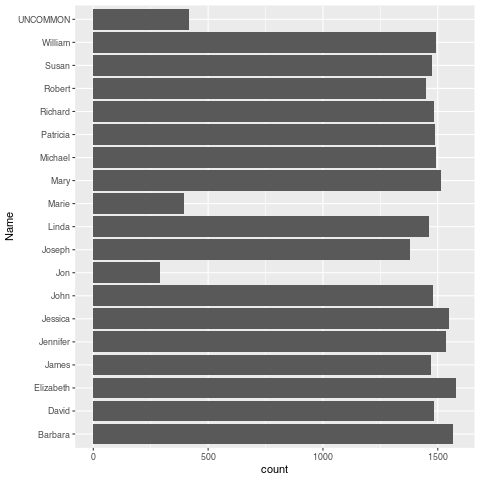

In [41]:
%%R
im <- ggplot(humans, aes(y = Name)) + geom_bar(stat = "count")
im

In [42]:
%%capture --no-stdout err
%%R
ggsave("img/(Ch07)name-histogram-with-uncommon.png", dpi=600)

In the next section, strings are considered again, but in the sense they are used in natural language processing, as texts of human languages which we might transform into numeric representations.

## String Vectors

> Get rid of meaning.<br/>–Kathy Acker

**Concepts**:

* Bag-of-words
* Word2Vec
* Cosine similarity
* Stop words, tokenization, lemmatization

Natural Language Processing (NLP) is  large subfield of data science.  The topic is deserving of numerous good books of its own, and fortunately many indeed exist.  For this book, we want to look only at one niche area; how can you encode strings of natural language into numeric features that machine learning models can accept as inputs and that statistical techniques can operate on?

Ordered historically, and in sophistication, there are two main methods of transforming a natural language text into a vector.  In the simplest case, we can use a technique called "bag-of-words."  This is simple enough as a technique that we can easily create this representation ourselves with a few lines of code.  The idea is first to construct a vocabulary for the entire *corpus*; that is, simply a collection of all the words it contains.  Then we can represent each text within it by a vector of the length of the vocabulary, with each component dimension indicating the count of that word.  It should be obvious that this can produce large vector sizes as corpora, and hence vocabularies, grow in size.  Even though it loses order of words, this encoding can be quite effective in producing useful vectors capturing semantic distinctions.

For a highly simplified example, suppose you have several pet stores in your town. Each publishes a catalog, with varying numbers of mentions of the two words *dog* and of *cat*.  Having a particular kind of pet (among these) yourself, you wish to determine which is likely to be more relevant for your pet care needs.  The vectors we generally use in NLP are likely to have hundreds or thousands of dimensions rather than two. 

<img src="img/dog_cat.png" width="40%"/>

In order to keep vocabularies at least relatively manageable, we can reduce words to simpler form.  We can discard punctuation and *canonicalize* case to arrive at fewer words.  Moreover, using the **NLTK** (Natural Language Toolkit) package, we can remove "stop words"—those usually small connecting words, pronouns, and a few others, that add little to the general semantics of a sentence.  Clearly, these are often necessary for clarity of human communication, but a vector representation of meaning usually does better without them.  For a simple example, let us choose a famous and powerful poem by an unfortunately politically authoritarian poet.

In [43]:
# William Butler Yeats
second_coming = """
Turning and turning in the widening gyre   
The falcon cannot hear the falconer;
Things fall apart; the centre cannot hold;
Mere anarchy is loosed upon the world,
The blood-dimmed tide is loosed, and everywhere   
The ceremony of innocence is drowned;
The best lack all conviction, while the worst   
Are full of passionate intensity.

Surely some revelation is at hand;
Surely the Second Coming is at hand.   
The Second Coming! Hardly are those words out   
When a vast image out of Spiritus Mundi
Troubles my sight: somewhere in sands of the desert   
A shape with lion body and the head of a man,   
A gaze blank and pitiless as the sun,   
Is moving its slow thighs, while all about it   
Reel shadows of the indignant desert birds.   
The darkness drops again; but now I know   
That twenty centuries of stony sleep
Were vexed to nightmare by a rocking cradle,   
And what rough beast, its hour come round at last,   
Slouches towards Bethlehem to be born?
"""

The first step is to determine the simplified words, and thereby the vocabulary, for our vector encoding.  First the poem itself is reduced to a sequence of more canonical words.  This is a form of *tokenization*, but a very simplified form.

In [44]:
def simplify_text(text):
    stops = nltk.corpus.stopwords.words('english')
    words = re.findall(r'[a-z]+', text.lower())
    return [w for w in words if w not in stops]

poem = simplify_text(second_coming)
poem[:6]

['turning', 'turning', 'widening', 'gyre', 'falcon', 'cannot']

From here we would like a mapping from the vocabulary to index positions within the vector.  The position of any particular word representation in the vector is irrelevant for this purpose, since each makes up an orthogonal axis of the vector.   For example, it doesn’t matter if "gyre" was chosen to be the second or sixth or twentieth element of the vector.  Our goal will be to encode each fragment using such a vector.  Trivially, a fragment might be a single word, but it might be a line, a paragraph, a stanza, or whatever other division we like.  The below code first creates a mapping of words to index positions, then generates the bag-of-words vectors.

In [45]:
word2ndx = {w:n for (n, w) in enumerate(set(poem))}
print(f"Vector dimensions={len(word2ndx)}")

def make_vector(words, word2ndx=word2ndx):
    # Generate the vector of zero count per dimension
    vec = np.zeros(len(word2ndx), dtype=np.uint16)
    for word in words:
        # we might ignore unknown word or attempt 
        # to canonicalize it, here we raise exception
        assert word in word2ndx
        n = word2ndx[word]
        vec[n] += 1
    return vec

list(word2ndx.items())[:5]

Vector dimensions=84


[('hardly', 0), ('turning', 1), ('tide', 2), ('vexed', 3), ('troubles', 4)]

To illustrate this bag-of-words vectorization technique, we can encode each stanza as a vector.

In [46]:
for i, stanza in enumerate(second_coming.split('\n\n')):
    print(f"Stanza {i+1}:")
    print(make_vector(simplify_text(stanza)))

Stanza 1:
[0 2 1 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 1 0 2 1 0 1 1 1 1 0 2 0 1 0 0 0
 0 0 1 0 0 1 1 1 0 0]
Stanza 2:
[1 0 0 1 1 1 1 0 1 0 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 2 1 1 1 1 1 1
 0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 2 2 1 2 0 1 0 0 1 0 0 0 0 1 0 1 0 1 1 1
 2 1 0 1 1 0 0 0 1 1]


These vectors represent a distinction between the "meaning" of the two stanzas.  Surprisingly to me—I did not realize until writing this paragraph—there are no word repetitions other than the stop words.  Within each stanza, various words are repeated, albeit only ever twice, not more than that.  As human readers, we certainly get a different "feel" from each stanza and would characterize its overall meaning differently.

Generally a more powerful vectorization technique than bag-of-words is *Word2Vec*.  This model allows you to create vectors of arbitrary dimensionality; but more importantly than that alone, Word2Vec uses a two-layer neural network that actually looks at the context of each word as defined by the words surrounding it.  This winds up producing vectors that are curiously meaningful.  Some commonly cited examples are the subtraction and addition of vectors with different components of their meaning.  For example, trained on a large typical English language corpus, we will likely see:

$$(cat - dog) \approx (kitten - puppy)$$

Or:

$$(china - beijing) \approx (turkey - ankara)$$

Depending on the corpus used in training, the second might be thrown off by the additional meaning of "turkey" as a flightless bird eaten especially in North America.  But then, "china" is also a word for porcelain dishes, which could have a similar homonym effect.

Building on word2vec is an improved version, called a "paragraph vector" by its original inventors, Quoc Le and Tomas Mikolov, but called *Doc2Vec* in the **gensim** package we utilize here.  Gensim is a very useful NLP package for Python that contains a number of useful NLP modeling tools; it is well-optimized for speed in its underlying libraries.  Also worth investigating is **spaCy**, which has a similar purpose, but with more pre-built models.  For many purposes, either vectorization is mostly similar, Doc2Vec primarily adds the ability to tag each document (e.g. a sentence, or a paragraph, or a stanza, or an entire book) by some attribute such as its author.  This tagging allows additional methods that characterize a tag (i.e. author) overall, and compare it to other tags or novel texts.

For this discussion, we will look at a collection of 14,485 tweets about airlines.  A corpus larger than the single poem we used above is useful, but there is no reason we could not use that in a similar way.  This data set has a number of things in addition to the tweets themselves.  Two such fields are name (of account) and airline.  The latter is somewhat redundant since it is determined based on the Twitter `@` tag that the user themselves attached.  Let us look at a few to get a sense.

In [47]:
db = sqlite3.connect('data/Airline-Tweets.sqlite')
cur = db.cursor()

sql = """
SELECT name, airline, text 
FROM Tweets 
"""
cur.execute(sql)
tweets = cur.fetchall()
pprint(tweets[5000:5003], width=60)

[('Paul_Faust',
  'United',
  '@united Love to report how horrible this flight is to '
  "your team. Let's make it worse...as they get to my "
  'seat...out of all snacks'),
 ('Jennsaint8',
  'Southwest',
  '@SouthwestAir any chance they will change this to '
  'include Northeast airports?  JetBlue has.'),
 ('_stephanieejayy',
  'Delta',
  '@JetBlue do you have any afternoon flights going from '
  'BQN to JFK? I only seem to find early morning flights.')]


It would definitely make sense to tag this corpus using the author; however, since each author will have written relatively few tweets, the more frequently occurring airline names are perhaps more interesting to use.  This choice is not too important for this book, but just something to illustrate.  We will use both tags to show the API.

In [48]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

docs = []
for (author, airline, msg) in tweets:
    td = TaggedDocument(simplify_text(msg), [author, airline])
    docs.append(td)

# Require words occur at least 4x, look 2 words to each side
# The produced vector is 10 dimensional
model = Doc2Vec(docs, vector_size=10, window=2, min_count=4)

Let us see how large our vocabulary is under the minimum count requirement and also look at a few of the example words<sup><i>stems</i></sup>.  The ordering of words in the vocabulary is again of no significance, as it was not with bag-of-words.  There are several thousands of words in the vocabulary, but we reduce the representation to an arbitrary dimensionality.  Here we choose 10 dimensions, which is probably sufficient for these fairly stereotyped messages.  A wider corpus with more semantic variation would probably benefit from higher dimensionality (the default if not specified is 100).

In [49]:
print("Number of words:", len(model.wv.vocab))
list(model.wv.vocab)[:7]

Number of words: 3359


['jetblue', 'new', 'ceo', 'seeks', 'right', 'balance', 'please']

<div id="stems"
     style="display: inline-block; margin: 0 5% 0 5%; border-style: solid; border-width: 1px">
    <i>stems</i><br/>
    
Identification of *words* is itself an important area of NLP.  Inflectional forms of the "same" word are often best treated as the same base form.  This is done either by *stemming* or by *lemmatization*. Stemming tries to identify a few letters making up a morphological root of a word by removing common affixes.  Lemmatization goes further by using both grammatical context and phonemic relations.  For example, a lemmatizer might canonicalize "dove" as a verb as "dive" (i.e. jump) but "dove" as a noun as "dove" (i.e. a bird).

Either technique would tread the word "seek" in the example as being identical to "seeks", "seeking", et cetera.
</div>

The purpose of this code we have run is to now be able to represent any string we might create as 10 numeric features. Novel strings may only utilizes terms in our vocabulary, but gensim provides a mechanism to construct a larger vocabulary alog with the model, including words that do not occur in the initial training set.  Let us first look at the vector for an existing tweet, then for a novel message.

In [50]:
msg = tweets[11_001][2]
print(msg)
model.infer_vector(simplify_text(msg))

@AmericanAir thank you for responding rather quickly btw


array([ 0.10738047, -0.05355555,  0.0755452 , -0.07259091,  0.06069977,
        0.0178712 , -0.09227157,  0.00020178, -0.04074618, -0.15264407],
      dtype=float32)

Below we create a short novel message and obtain its vector.  These dimensions have no particular meaning, but we are able to measure the relationships between them.  We can also store this synthetic data in intermediate data sets that might be used for downstream modeling techniques; this latter is the most common use for this transformation.

In [51]:
badservice = model.infer_vector(['bad', 'service'])
badservice

array([ 0.03610117, -0.03151792, -0.02503213, -0.02327876,  0.02641516,
       -0.00222431,  0.00556235,  0.00205062,  0.02676179, -0.01094392],
      dtype=float32)

The gensim library provides a rich set of functions to compare these representations, using cosine similarity and other techniques.  Just as one example, let us see which single words are closest to my short message, "bad service." A small note is that I have frozen this next output; the neural network underlying Doc2Vec has state randomization, so each time it is trained, different vectors, and different connection weights in the underlying neural network, are produced.  Here I display the result from one particular run, but other runs will vary in details.

```python
>>> model.wv.most_similar(['bad', 'service'])
```

```
[('terrible', 0.9658449292182922),
 ('clients', 0.9587224125862122),
 ('management', 0.9491853713989258),
 ('greeting', 0.9436992406845093),
 ('msy', 0.9382249116897583),
 ('pathetic', 0.9378621578216553),
 ('dropped', 0.9307988286018372),
 ('keeping', 0.9277007579803467),
 ('lack', 0.924517035484314),
 ('telling', 0.9227219223976135)]
```

Most of those words are directly negative, the ones that seem neutral or positive probably occur mostly in contexts that negates their ordinary meanings in some sense. For example, perhaps "management" is usually surrounded by negative adjectives in the tweets.  We can also utilize the tags to get vectors that simply represent the collection of texts associated with the tag.  We could make measurements from these vectors in the parameter space to those for additional airlines, or to particular texts expressing a sentiment, and this would illustrate the similarity of those various vectors.

In [52]:
airlines = ('Delta', 'United', 'JetBlue')
delta, united, jetblue = (model.docvecs[x] for x in airlines)
print(f"Delta:\n{delta}\n")
print(f"United:\n{united}\n")
print(f"JetBlue:\n{jetblue}\n")

Delta:
[  2.9723108   -6.1970453    2.5318384   -7.5126486    5.626745
  -3.7542846   -2.3669784   -3.685907    -0.30052716 -10.938991  ]

United:
[ 8.651637   -3.9246778   6.329406   -3.3211803   4.7610464   0.9626462
  1.733406   -0.09308968  3.17078    -9.539236  ]

JetBlue:
[ 0.02832068 -0.04865979 -0.02008577  0.00769677  0.03915345  0.02498608
  0.04107957  0.01846196  0.01812948  0.02923545]



How similar are what people tweet about these airlines, as a per airline comparison?

In [53]:
from scipy.spatial.distance import cosine
print(f"Delta  | United  | {cosine(delta, united):.3f}")
print(f"Delta  | JetBlue | {cosine(delta, jetblue):.3f}")
print(f"United | JetBlue | {cosine(united, jetblue):.3f}")

Delta  | United  | 0.241
Delta  | JetBlue | 1.053
United | JetBlue | 0.780


We can see that Delta and United are quite similar in this analysis, but Delta and JetBlue are nearly as distant in vector space as is possible.  I.e. a value of zero would mean identical "sentiment" vectors, while a value of one would be maximally different.  This is a good time to continue thinking about vector spaces in an abstract sense.

## Decompositions

> After the entropy is accounted for, all that is left is noise.<br/>–David Mertz

**Concepts**:

* Principal Component Analysis and other decompositions
* Whitening
* Dimensionality reduction
* Visualization with t-SNE and UMAP

A highly dimensional data set—whether of high dimension because of the initial data collection or because of creation of extra synthetic features—may lend itself less well to modeling techniques.  In these cases, it can be more computationally tractable, as well as more predictive, to work with fewer features.  Feature *selection* is mostly outside the scope of this book, but is discussed briefly in the below section on *Polynomial Features*, which is the technique that increases the number of synthetic features most dramatically.

However, one special kind of "feature selection" is a *decomposition* of the parameter space of a feature set.  These techniques presuppose that all features have been numerically encoded in some manner, perhaps via the technique discussed below in the *One-Hot Encoding* section.  A decomposition creates synthetic features in a sense, but what it really does is create new *orthonormal basis* (new axes) of the parameter space.  The transformation in a decomposition is information preserving and reversible *if* you keep the same number of dimensions as in the prior data set.  However, the purpose of a decomposition is most often to perform *dimensionality reduction*.  When a decomposition is performed on multi-dimensional data, it concentrates the entropy of the data into the initial dimensions, leaving much less information content in the remaining dimensions; often discarding the higher-numbered dimensions does little harm to modeling metrics, or indeed improves them.

The most common, and oldest, decomposition technique is *principal component analysis* (PCA), which was first developed by Karl Pearson in 1901.  We will primarily focus on PCA in this section, but just keep in mind that other techniques might prove more powerful for specific data sets and domain characteristic distributions of values.  Some of these other techniques include *non-negative matrix factorization* (NMF), *latent Dirichlet allocation* (LDA), *independent component analysis* (ICA), and *t-distributed stochastic neighbor embedding* (t-SNE).  The last listed technique, t-SNE, is not reversible, however, so is not quite accurately characterized as a decomposition, but it *is* a dimensionality reduction that is very oten useful for visualization, and we will look at an example of that.  Conveniently, all of these decompositions (as well as others) are provided by scikit-learn; each is certainly available in other libraries as well, of course.

### Rotation and whitening

As an initial example, let us look at a data set with just two features, and perform a decomposition on it.  When we perform a decomposition we emphasize the "most important synthetic axes."  The result of this for PCA specifically is that, by definition, the variance decreases with each successive PCA feature.  *Whitening* and *sphering* are synonyms meaning re-scaling these synthetic features.

With a decomposition, there can be a secondary de-emphasis of some features that is too strong.  It depends on the specific kind of model used, but for many models a numeric feature ranging from 0 to 100 will simply have more effect than a feature varying from 0 to 1 just because it contributes *bigger* numbers to the calculation.  Usually it is better to let a model select the importances of features than to judge it in advance with feature engineering. That is, a decomposition—or other feature engineering technique—might give a synthetic feature a numeric scale greater or less than some other feature, and hence a corresponding default weighting.  It is best to avoid that, as we do below.

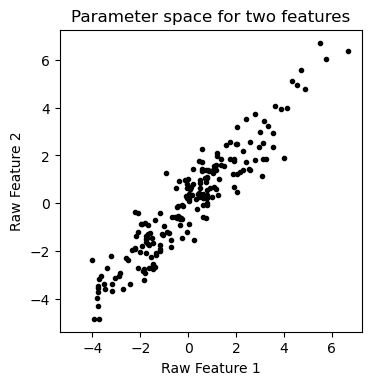

In [54]:
from src.whiten import data, show

# Only two initial features for illustration, 
# but in general we would have a highly dimensionality
show(data, "Parameter space for two features", 
     "Raw Feature 1", "Raw Feature 2")

Here we have two features that are obviously pretty strongly correlated.  In particular though, we notice that the variance is greater along a diagonal of roughly 45° than along the observed axes.  PCA will reorient the data to make this axis of variance (i.e. the most entropy) the primary component.

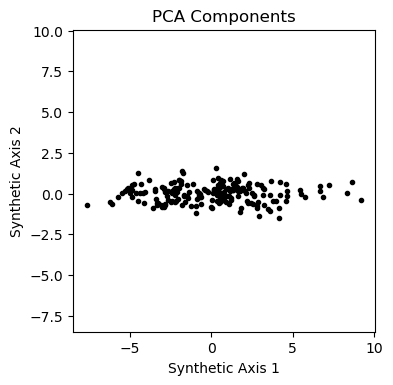

In [55]:
from sklearn.decomposition import PCA
show(PCA().fit_transform(data), 
     "PCA Components", "Synthetic Axis 1", "Synthetic Axis 2")

We looked at scaling in more detail in chapter 5 (*Data Quality*).  We could use those standard techniques to scale this "flattened" data, but this concern is common enough in PCA transforms that scikit-learn builds in an argument to do it automatically.  This often saves us the need to rescale data a second time after the transform, and is generally a cleaner approach.

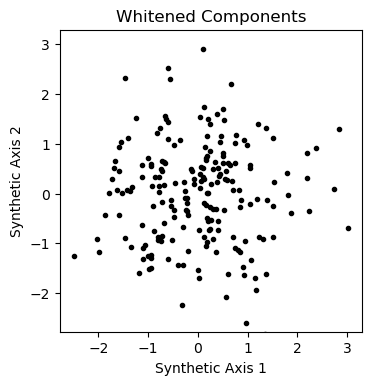

In [56]:
show(PCA(whiten=True).fit_transform(data), 
     "Whitened Components", "Synthetic Axis 1", "Synthetic Axis 2")

The use of "whitening" is closely analogous to the distinction between "white noise" and "pink noise" in acoustics and spectral analysis.  Both kinds of noise represent a wide range of frequency values, but "pink" overemphasizes the red end of the visual spectrum.  Similarly, a non-whitened PCA would overemphasize one particular axis.

### Dimensionality Reduction

While a change to the orthonormal basis might in itself aid machine learning models, the more common use of decomposition is to reduce the number of dimensions while still retaining most of the information.  As an example, let us use the widely available Wisconsin Breast Cancer Data Set.  This can be obtained from the UCI Machine Learning Repository, from Kaggle, or included with scikit-learn and other data science libraries.  In summary, this data set contains 30 numeric measurements of tumors, with a target characterization as benign or malignant.  It has 569 observations that are relatively well balanced between the target classes (212 malignant, 357 benign).

In [57]:
cancer = load_breast_cancer()
X_raw = StandardScaler().fit_transform(cancer.data)
y = cancer.target

If we try to make a prediction using a typical machine learning model, we can do *pretty well* with a naïve approach.  In order to illustrate this, we perform a train/test split to avoid overfitting the specific data used to train the model.  This is outside the direct scope of this discussion, but a line of code below performs that.  We can also reduce the dimensionality using PCA, and the effect on the model quality is interesting.  For this discussion, we will try selecting just one principal component, only two components, and four components, derived from the original 30 features.  We whiten in each case to preserve scales of dimensions (this is generally moot for the PCA1 case).

In [58]:
X_pca1 = PCA(n_components=1, whiten=True).fit_transform(X_raw)
X_pca2 = PCA(n_components=2, whiten=True).fit_transform(X_raw)
X_pca4 = PCA(n_components=4, whiten=True).fit_transform(X_raw)

Using our three candidate feature matrices, let us see how well the corresponding K-neighbors models perform.

In [59]:
for X in (X_raw, X_pca1, X_pca2, X_pca4):
    X_train, X_test, y_train, y_test = (
        train_test_split(X, y, random_state=1))
    model = KNeighborsClassifier().fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    error_rate = 100*(1-accuracy)
    print(f"Features | {X.shape=}\t| {error_rate=:.2f}%")

Features | X.shape=(569, 30)	| error_rate=4.90%
Features | X.shape=(569, 1)	| error_rate=9.79%
Features | X.shape=(569, 2)	| error_rate=6.99%
Features | X.shape=(569, 4)	| error_rate=4.20%


An error rate of 4.90% on the raw data is not too unreasonable.  In any case, let us consider that a baseline.  With only one principal component, the error rate jumps to 9.79%; this is surprisingly good given how much information we discarded, and is better than we could have done utilizing any single raw feature.  If we keep two principal components, the error rate falls to 6.99%, which is a sensible intermediate value.  However, what is intriguing is that with four principal components, we actually get a slightly better error rate, of 4.20%, than we achieved with the complete raw data.  In essence, after the bulk of the entropy in the data is accounted for, all that is left is random noise.

This contrast between "entropy" and "noise," while accurate, is also meant as a playful phrasing.  Entropy and noise are treated as synonyms in many contexts, although "information content" is actually closer to the meaning of entropy.  But the underlying point is that some of the variability in observations is due to the underlying natural (or artificial) phenomenon, and some of it is due exclusively to the random variation of sampling a finite population.  Dimensionality reduction via decomposition has a tendency to pick out the signal from the noise.  I will note that there remains trial and error here; for example, choosing five or six components rather than four becomes worse than the raw data again (on this exact model algorithm, with this exact train/test split, with these exact hyperparameters, et cetera).

Let us return to exactly what PCA does as a transformation.  It simply determines multipliers for each of the raw dimensions to linearly derive the principal components.  For example, in the breast cancer data set, each observation is a vector of 30 numbers.  Each of those numbers is multiplied by some constant, and those 30 products are added together to make up component 1.  Likewise for component 2, with different multipliers.  Let us create a table of these multipliers for `n_components=3` to illustrate.

In [60]:
pca3 = PCA(n_components=3).fit(X_raw)
pd.DataFrame(pca3.components_.T, 
             index=cancer.feature_names, 
             columns=['pca_1', 'pca_2', 'pca_3'])

pca_1     pca_2     pca_3
mean radius              0.218902 -0.233857 -0.008531
mean texture             0.103725 -0.059706  0.064550
mean perimeter           0.227537 -0.215181 -0.009314
mean area                0.220995 -0.231077  0.028699
...                           ...       ...       ...
worst concavity          0.228768  0.097964 -0.173057
worst concave points     0.250886 -0.008257 -0.170344
worst symmetry           0.122905  0.141883 -0.271313
worst fractal dimension  0.131784  0.275339 -0.232791

[30 rows x 3 columns]

In other words, we can use the `.transform()` method of the fitted PCA object, but we can equivalently just perform the same calculation in plain NumPy.

In [61]:
row0_sk = pca3.transform(X_raw)[0]
row0_np = (pca3.components_ * X_raw[0]).sum(axis=1)
print(f"Row 0 as transform: {row0_sk}")
print(f"Row 0 as mul/sum:   {row0_np}")

Row 0 as transform: [ 9.19283683  1.94858306 -1.12316514]
Row 0 as mul/sum:   [ 9.19283683  1.94858306 -1.12316514]


### Visualization

For different purposes, utilizing a different decomposition can be useful.  Principal component analysis, however, remains the first technique you should try in most cases.  One special use is when we want to generate useful visualizations of high dimensional parameter spaces into the two or three dimensions we can actually represent spatially. T-distributed Stochastic Neighbor Embedding (t-SNE) is a nonlinear dimensionality reduction technique for projecting high-dimensional data into two or three dimensions. Similar objects are modeled by nearby points and dissimilar objects are modeled by distant points, with high probability. 

As an example of this visualization technique, let us look at a collection of 1,797 hand written digits scanned as 8×8 grayscale pixels.  This collection is one of those published in the UCI Machine Learning Repository and distributed with scikit-learn.  What this amounts to is a 64-dimensional parameter space for the various pixel values.  Relatively simple models like logistic regression can get good results in predictive accuracy on this data set; convolutional neural networks do even better.  Let us look at a few sample scans and import the underlying data.

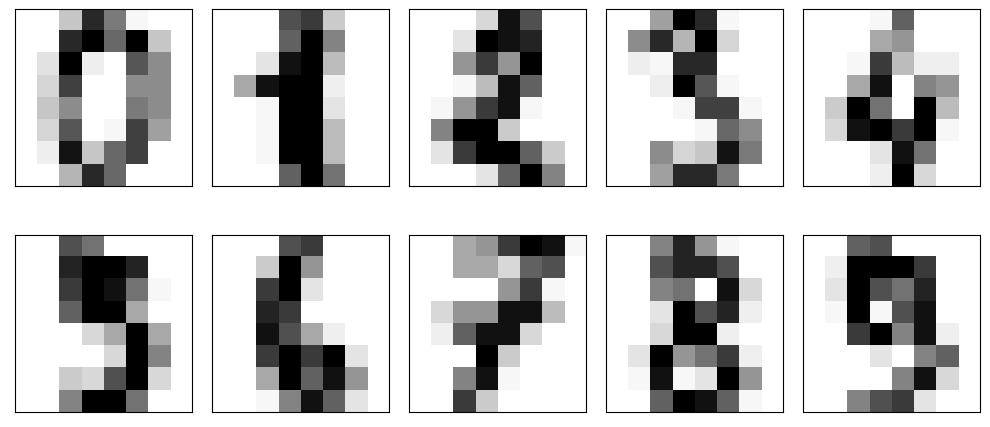

In [62]:
digits = get_digits()

We might try to simplify this 64-dimensional parameter space using PCA.  That will indeed get us a 2-D visualization that shows reasonable differentiation of digits in this projected parameter space.  There is certainly, for example, a region toward the top-center of the plot below that is dominated by the digit '0'.  At the same time, there is strong overlap between the regions where digits occur, and somewhat loose differentiation.

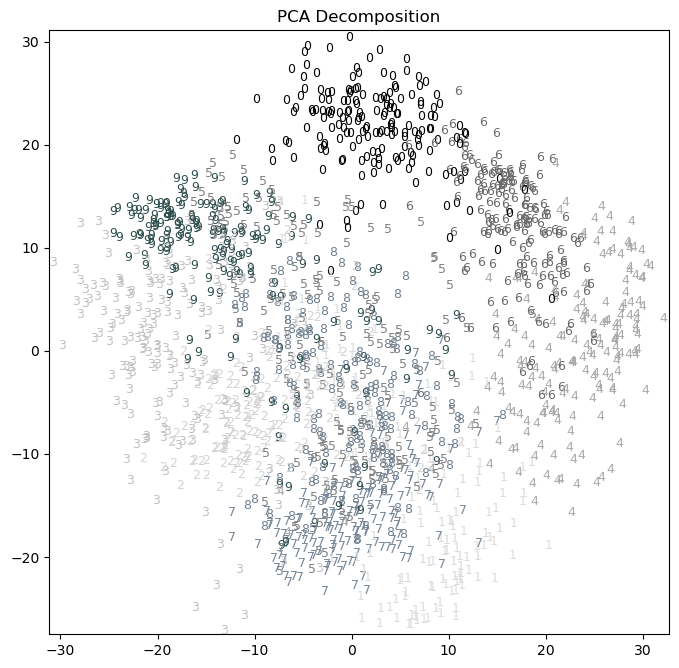

In [63]:
pca_digits = PCA(n_components=2).fit_transform(digits.data)
plot_digits(pca_digits, digits, "PCA")

The scale units of the PCA dimensionality reduction, and those below of other techniques have no specific numeric meaning.  They are simply artifacts of the algorithms, but produce differentiated numbers that can be plotted, or used in statistics or modeling.

In contrast, using t-SNE we achieve a much stronger result for this visualization.  Correspondingly, modeling based on this projection will provide much more to work with.  In this example, t-SNE plus logistic regression does not perform better than the logistic regression on the full feature space, but it is not that much worse with far less underlying data used to represent each observation.  The cluster of '0' digits at the center-left, for example is extremely strong, with a large gap between those and any other digits.  A few others are less well separated, but in the ways we would tend to expect; a '9' drawn a certain way strongly resembles a '3', for example.  

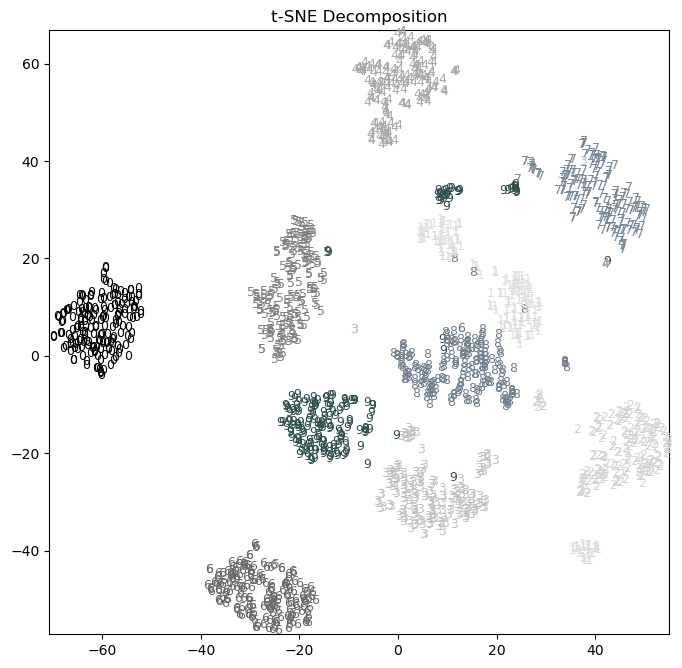

In [64]:
tsne_digits = TSNE(random_state=1).fit_transform(digits.data)
plot_digits(tsne_digits, digits, "t-SNE")

Uniform Manifold Approximation and Projection for Dimension Reduction (UMAP) is another technique with a similar motivation (but very different math) as t-SNE. UMAP often has additional advantages.  Specifically, the distance *between* clusters—not only the closeness of observations *within* a cluster—is roughly preserved by UMAP, whereas t-SNE simply does not attempt to do that.  In this particular scanned digits example, UMAP produces even tighter clusters than does t-SNE as well.  In fact, the clusters are tight enough that it is difficult or impossible to distinguish the many overlain digits within each cluster.

```python
from umap import UMAP
umap_digits = UMAP(random_state=1).fit_transform(digits.data)
plot_digits(umap_digits, digits, "UMAP")
```
<img src="img/UMAP-decomposition.png" width="70%" />

In using a decomposition technique to generate synthetic features, you are not, of course, limited to using only those features.  Depending on your specific needs, it can make sense to utilize a top few decomposed dimensions, but also add those into the same intermediate data set with some original raw features, with one-hot encoded features, with polynomial features, or with other types of synthetic data.  This task-specific construction of a data set is likely to be most effective for the particular purpose you have in front of you.  Obviously, a lot of gut feeling, some reasoning, and a lot of trial and error, are needed to arrive at the best data to work with.

Let us look at turning continuous measurements into ordinal data which can often increase the power of models.

## Quantization and Binarization

> I only like two kinds of men, domestic and imported.<br/>
> –Mae West

**Concepts**:

* Decreasing granularity
* Balancing bin size
* Setting thresholds

There are times when continuous—or even simply ordinal—data is more usefully represented by a small number of levels.  At the limit of that, we may reduce a numeric range to just two values: True/False or 1/0 generally, but other values can work.  At this limit, *quantization* is known as *binarization*.  Using a quantization transformation is often useful when data as represented has more precision than is genuinely meaningful—either from the perspective of the accuracy of measurements, or from the perspective of utility to our data science task.

As a simple example for this section and the next one, I will use the results of a survey I conducted on students in a half-day tutorial on scikit-learn I gave at a conference.  I sometimes use this same data in other training as a quick data set for performing machine learning.  What is presented here removes some of the features, but retains those useful for these sections.  Like all data, this data set is messy; some cleanup was done, but a few elements were deliberately eschewed to provide you a real-world mess (but not *too dirty* to be useful).

In [65]:
survey = pd.read_csv('data/ML-survey.csv')
survey.sample(6, random_state=1)

Language  Experience  Age  Post_Secondary  Success
95       C++         1.0   57              12        7
44    Python         7.0   24              11        5
56         R         2.0   46               9       10
97    Python         2.0   23               3        5
69    Python         5.0   53               4        8
114   Python        25.0   76              23        1

This data is simple enough.  Some biographic data was collected about tutorial attendees, and they were asked to evaluate how successful the tutorial was on a 1-10 scale.  A tiny bit of domain knowledge will tell you that on ratings like this the distribution of responses is highly skewed.  In essence, a 9 or 10 is a strong positive, and anything 7 or less is negative.  A response of 8 is moderately positive.  Perhaps one might hope for more uniformity across the range, but human psychology and a history of social pressures around how to respond to such evaluations makes this so.  These data follow this familiar pattern.

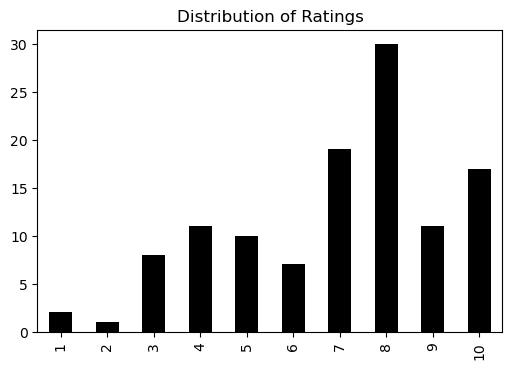

In [66]:
title="Distribution of Ratings"
(survey
    .Success
    .value_counts()
    .sort_index()
    .plot(kind='bar', title=title))
plt.savefig(f'img/(Ch07){title}.png')

Given the distribution of data, the known psychology of ratings, and a stipulated analytic purpose, we wish to treat the rated success simply as a binary value.  This can be done very easily in Pandas—or almost identically in every other data frame library—by a simple comparison that creates a Boolean array.  These Boolean arrays are often used as filters or masks, but they can equally provide perfectly good values directly.

In [67]:
survey.Success >= 8

0       True
1       True
2       True
3      False
       ...  
112    False
113     True
114    False
115     True
Name: Success, Length: 116, dtype: bool

If you are working with raw arrays, in NumPy or other libraries, you may wish to use the scikit-learn class `Binarizer`.  This utility always expects a two-dimensional matrix as input, but a matrix with a single column is perfectly acceptable.

In [68]:
from sklearn.preprocessing import Binarizer

# Set threshold anywhere *between* 7 and 8
binary_rating = Binarizer(threshold=7.5)

# Pass 2-D DataFrame, not Series
success = binary_rating.fit_transform(survey[['Success']])

# Maintaining versions is good practice
survey2 = survey.copy()
survey2['Success'] = success
survey2

Language  Experience  Age  Post_Secondary  Success
0     Python        20.0   53              13        1
1     Python         4.0   33               7        1
2     Python         1.0   31              10        1
3     Python        12.0   60              12        0
..       ...         ...  ...             ...      ...
112   Python         4.0   35               4        0
113   Python         3.0   44               6        1
114   Python        25.0   76              23        0
115   Python        25.0   75              12        1

[116 rows x 5 columns]

Binary values are well-suited for the `Success` measure.  For other columns, we would like to treat them somewhat differently.  Let us look at how the amount of post-secondary education of attendees was distributed; we will treat it somewhat differently.

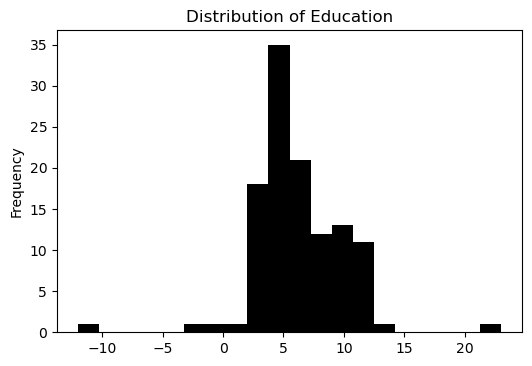

In [69]:
title="Distribution of Education"
(survey2
    .Post_Secondary
    .plot(kind="hist", bins=20, title=title))
plt.savefig(f'img/(Ch07){title}.png')

There are two apparent outliers in the data.  One respondent claimed 23-years of post-secondary education.  That same respondent happens to be visible above as row 114, and the respondent reported being 76 years old.  Given that the survey intention and description was along the lines of noting a doctorate or equivalent profession degree as 10 years, the 23 is somewhat suspicious; possibly this same person has a Ph.D., M.D., and J.D. to add to that number, but more likely there was some failure in communicating the intention, or an entry error.  Nonetheless, for our binning, we will just stipulate that that person will go in the most-education category.

The second outlier is -12, which is simply a nonsensical value.  The intention, in any case, was that no college education would be noted as zero, not by some subtraction for years-until-college.  Perhaps a third-grader attended and felt that was a best description.  Or again, more likely there was a data-entry error.  We will simply code this as the least-education category, in this case.  For another purpose, you might reflect on techniques discussed in chapter 6 (*Value Imputation*) to treat the illegal value. Rather than preserve the exact years of education, we will only store values corresponding to "least-education", "mid-education", and "most-education"—numerically coded just as 0, 1, 2.  Our project documentation should describe this mapping.

To divide the data into roughly equally sized bins based on amount of education, we can use the scikit-learn class `KBinsDiscretizer`.  As elsewhere in the scikit-learn API, we first create a parameterized instance of the class, then perform a `.fit_transform()` to transform the data.

In [70]:
from sklearn.preprocessing import KBinsDiscretizer

# Create a binner with 3 balanced bins
edu_bin = KBinsDiscretizer(n_bins=3, 
                           encode='ordinal', 
                           strategy='quantile')

# Bin the Post_Secondary column
level = edu_bin.fit_transform(survey2[['Post_Secondary']])

# In this version, rename the binned field "Education"
survey3 = survey2.copy()
survey3['Education'] = level.astype(np.uint8)
survey3.drop('Post_Secondary', axis=1, inplace=True)
survey3.sample(8, random_state=2)

Language  Experience  Age  Success  Education
24      Python         3.0   28        1          0
89      Python        12.0   46        0          2
28      Python         3.0   31        1          1
56           R         2.0   46        1          2
2       Python         1.0   31        1          2
53      Python        10.0    3        1          2
45      Python         1.0   31        0          2
79  JavaScript         1.0   32        1          1

We can see generally that `Education` values are 0, 1, or 2 as anticipated.  We can look in more detail to see what cut-offs were selected and how many respondents fall into each category.  Note that although I am describing these as categories (and expect a mapping documenting the keys), these are clearly ordinally arranged, not categorical.

In [71]:
print("Education cut-offs:")
print(edu_bin.bin_edges_[0], '\n')
print("Count per bin:")
print(survey3.Education.value_counts())

Education cut-offs:
[-12.           4.33333333   7.          23.        ] 

Count per bin:
2    44
0    39
1    33
Name: Education, dtype: int64


For education, we allowed the utility to decide the cut-points for balanced bins.  However, perhaps we would rather divide into fixed numeric ranges for a particular feature.  Let us try that approach for the `Experience` value (intended to reflect years of programming experience).  `KBinsDiscretizer` can simply be instantiated with different parameters to achieve this.  Again we need to document that numbers 0, 1, 2, 3, 4 are used to denote experience ranges rather than raw years; however, here we retain the same column name in the new data set version.

In [72]:
# Create a binner with 5 bins of same numeric range
exp = KBinsDiscretizer(n_bins=5, 
                       encode='ordinal', 
                       strategy='uniform')

# Bin the Experience column
exp_level = exp.fit_transform(survey3[['Experience']])

# Retain the Experience name, but new meaning
survey4 = survey3.copy()
survey4['Experience'] = exp_level.astype(np.uint8)
survey4.sample(8, random_state=3)

Language  Experience  Age  Success  Education
83    MATLAB           1   37        0          2
5     Python           0   32        1          0
6     Python           0   34        0          2
42    MATLAB           0   31        0          2
100   Python           0   47        0          2
97    Python           0   23        0          0
40    Python           1   33        1          2
25         R           0   36        1          0

The result of using the "uniform" strategy for binning produces strongly imbalanced bins.  However, that is perfectly reasonable in many cases, including most likely this one.  In our broader purpose, rounding amount of experience to rough multiples of 5 years might be a good simplification.  If we varied this technique modestly, we could make those cuts at exactly 5 years, but approximately that range was obtained by regularly cutting the data itself.

In [73]:
print("Experience cut-offs:")
print(exp.bin_edges_[0], '\n')
print("Count per bin:")
print(survey4
        .Experience.value_counts()
        .sort_index())

Experience cut-offs:
[ 0.   5.4 10.8 16.2 21.6 27. ] 

Count per bin:
0    93
1    14
2     4
3     1
4     4
Name: Experience, dtype: int64


In each of the prior quantizations, we encoded values as ordinals.  However, another approach is sometimes better.  We might consider the different numeric ranges of a value as genuinely categorically different, rather than as ordinals or even as purely quantitative.  Education was treated in an ordinal way, since the increments were uneven.  But experience is simply continuous but quantized.  To an approximation, recovering the original measurement is simply multiplying each value by 5.4, in that case.  For certain measurements, different values may refect different domains or regimes.  For those, we can use one-hot encoding, which is discussed in the next section but is available as a parameter of `KBinsDiscretizer` as well.

Although I believe it is fanciful for this example, let us stipulate that "Young", "Mid_Age", and "Old" tutorial attendees are wholly different kinds that we wish to distinguish (your author will be lumped into the last of those domains).  Before we do that, however, we have to handle a data quality issue.  Some age values look suspicious.

In [74]:
survey4.Age.describe()[['mean', 'min', 'max']]

mean    36.965517
min      3.000000
max     99.000000
Name: Age, dtype: float64

In [75]:
survey[survey.Age < 10]

Language  Experience  Age  Post_Secondary  Success
53   Python        10.0    3               9        9
85   Python         3.0    3              10        6

There was conceivably a 99 year old in the tutorial, but there were certainly no 3 year old attendees.  Although the 99 year old was *probably* an inaccurate entry, the 3 year olds are provably wrong from the data itself, since  their programming experience and post-secondary education each exceed their age.  I will assume that these are 30-something attendees who made data-entry errors, and impute an age of 35 to both of them (not far from the median or mean age of all attendees, which I might also reasonably use).

In [76]:
# Create next version and impute for bad data
survey5 = survey4.copy()
survey5.loc[survey5.Age == 3, 'Age'] = 35

# Create a binner with 3 bins to 3 columns
# Note: a sparse array with "onehot"
age_bin = KBinsDiscretizer(n_bins=3, 
                           encode='onehot-dense', 
                           strategy='quantile')

# Bin and split the Age column
age = age_bin.fit_transform(survey5[['Age']])
age = age.astype(np.uint8).T
survey5 = survey5.assign(Young=age[0], 
                         Mid_Age=age[1], 
                         Old=age[2])
survey5.drop('Age', axis=1, inplace=True)
survey5.sample(8, random_state=4)

Language  Experience  Success  Education  Young  Mid_Age  Old
13      Python           0        0          2      0        1    0
2       Python           0        1          2      0        1    0
25           R           0        1          0      0        1    0
16      Python           0        1          0      0        0    1
19      Python           0        0          1      0        0    1
79  JavaScript           0        1          1      0        1    0
5       Python           0        1          0      0        1    0
24      Python           0        1          0      1        0    0

Having created synthetic columns for age ranges using one-hot encoding, this is a good point to turn to the next section that discusses one-hot encoding in general.  We will continue to work with this survey data set that we have massaged and transformed in stages.

## One-Hot Encoding

> If once a man indulges himself in murder, very soon he comes 
> to think little of robbing; and from robbing he next comes to 
> drinking and Sabbath-breaking, and from that to incivility 
> and procrastination.  Once [begun] upon this downward path, 
> you never know where you are to stop. Many a man has dated 
> his ruin from some murder or other that perhaps he thought 
> little of at the time. <br/>–Thomas de Quincey

**Concepts**:

* Avoiding artificial ordering
* Synthetic boolean features

Very commonly, we work with features that have a number of class values encoded in them. For many models or other statistical techniques, we require features to be encoded as numbers.  An easy way to do that is encoding values as numeric ordinals.  For example, in the survey data, we *could* encode the language feature by mapping Python=1, R=2, JavaScript=3, and so on.  While those values are numeric, we often get better quality if we do not impose an artificial ordering to the categories.  Different programming languages have no inherent or obvious ordering among them.

The encoding of class values may not be as meaningful strings, but may already use a range of small integers.  This can falsely suggest ordinality to a variable.  We should consult documentation and domain knowledge to determine if that is a reasonable interpretation for a particular feature.  Symmetrically, of course, strings sometimes actually do encode clearly ordinal values; e.g. "Poor", "Good", "Best" in an evaluation of something (the meaningful order is unlikely to be the "natural" order of those strings, such as alphabetical).

To encode one feature with multiple values, we can transform it into multiple features, one for each class value.  The "one-hot" in the name of this encoding indicates that exactly one of these new features will have a one, and the others will be zeros (or alternately True/False, depending on your programming language and library).  The favorite programming language column of the survey data set is a good candidate for one-hot encoding.

In Pandas, the `get_dummies()` function transforms a data frame into one-hot encoding.  In scikit-learn, the class `OneHotEncoder` performs the same task, but is not limited to working with Pandas (anything matrix-like works).  In both APIs you have a variety of options to provide the naming of the new features, whether to use dense or sparse arrays for storage, whether to omit one category (to reduce multicollinearity), and in Pandas which columns to encode.  By default, Pandas will look for all string or categorical columns, but you can tweak that; for example, you may want to force one-hot encoding of an integer column.

For presentation, we display a transposed data frame with a sample of a few rows and the encoded language features as rows.  We can see that most samples (here shown as columns) have a 1 in the `Lang_Python` feature, and 0 for other features.  A few of the samples have their "one hot" in a different feature.

In [77]:
survey6 = pd.get_dummies(survey5, prefix="Lang")
survey6.sample(10, random_state=3).T.tail(8)

83   5    6    42   100  97   40   25   115  103
Lang_C++           0    0    0    0    0    0    0    0    0    0
Lang_JavaScript    0    0    0    0    0    0    0    0    0    0
Lang_MATLAB        1    0    0    1    0    0    0    0    0    0
Lang_Python        0    1    1    0    1    1    1    0    1    0
Lang_R             0    0    0    0    0    0    0    1    0    1
Lang_Scala         0    0    0    0    0    0    0    0    0    0
Lang_VB            0    0    0    0    0    0    0    0    0    0
Lang_Whitespace    0    0    0    0    0    0    0    0    0    0

The scikit-learn API is similar to other transformers we have looked at.  We simply create a parameterized instance, then fit and/or transform data using it.  Under this API, the metadata such as suggested feature names lives in the encoded object and the raw encoded data is a plain NumPy array.

In [78]:
from sklearn.preprocessing import OneHotEncoder
lang = survey5[['Language']]
enc = OneHotEncoder(sparse=False).fit(lang)
one_hot = enc.transform(lang)
print(enc.get_feature_names())
print("\nA few encoded rows:")
print(one_hot[80:90])

['x0_C++' 'x0_JavaScript' 'x0_MATLAB' 'x0_Python' 'x0_R' 'x0_Scala'
 'x0_VB' 'x0_Whitespace']

A few encoded rows:
[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]]


With our transformation we have arrived at a data set with more features, but ones better suited to our downstream purposes.  Let us look at just one row since the DataFrame has become too wide to display easily in this space.  The particular encodings we have performed all give us small non-negative integers, in this example, but this could easily be combined with other continuous numeric variables, perhaps with those scaled to a similar numeric range as these small numbers. 

In [79]:
with show_more_rows():
    print(survey6.loc[0])

Experience         3
Success            1
Education          2
Young              0
Mid_Age            0
Old                1
Lang_C++           0
Lang_JavaScript    0
Lang_MATLAB        0
Lang_Python        1
Lang_R             0
Lang_Scala         0
Lang_VB            0
Lang_Whitespace    0
Name: 0, dtype: int64


One-hot encoding is one small step towards increasing dimensionality with synthetic features.  Next we turn to a truly giant leaps with polynomial features.

## Polynomial Features

> In the final analysis, a drawing simply is no longer a 
> drawing, no matter how self-sufficient its execution may 
> be. It is a symbol, and the more profoundly the imaginary 
> lines of projection meet higher dimensions, the better.<br/>
> –Paul Klee

**Concepts**:

* Generating synthetic features
* The curse of dimensionality
* Feature selection

Generating polynomial features can create a large number of new synthetic features.  The basic idea behind this transformation is simple: we add new features that are the multiplicative product of up to N of the existing features.  In the scikit-learn version we will use in this section, `PolynomialFeatures` does a multiplication of all combinations of parameters (up to specified degree).  It is, of course, easy enough to create multiplicative, or other, combinations of features manually.  The `PolynomialFeatures` wraps up identifying all combinations and providing a general transformer object with useful metadata, in one API that is familiar to users of other scikit-learn classes.

Constructing polynomial features is often the main reason we need subsequently to winnow features using feature selection.  Reducing 30 raw features to 15, for example, is unlikely to be hugely important to most models.  But reducing the 496 synthetic features in the below example becomes important to both the power of a model and computational resources used.  If we construct a much larger number of synthetic polynomial features, the imperative for feature selection becomes that much stronger.  It is quite common that a combination of polynomial expansion combined with feature selection produces greatly stronger models than raw features can.

Scikit-learn provides a detail about whether to create the squares (or cubes, etc) of single features, which is not terribly important in an overall data pipeline most of the time.  I generally feel there is no harm in including those terms, and occasionally there is benefit.  If the `interactions_only` option is not used, the number of produced features is:

$$ \#features = N + N + \frac{N \times (N-1)}{2} + 1 $$

For example, for 30 raw dimensions, we obtain 496 polynomial features, at degree 2; for 100 raw features, we get 5151.  In this section, we return to the Wisconsin Breast Cancer Data Set also used earlier in this chapter.  Recall that it has 30 numeric features (and one binary target).

In [80]:
cancer = load_breast_cancer()
X_raw = MinMaxScaler().fit_transform(cancer.data)
y = cancer.target

### Generating Synthetic Features

Creating the polynomial features is simply another transform, much like all the other transformers in scikit-learn that we have looked at in this book.  We only pay much attention in this section to the degree 2 polynomial, but for an illustration of the growth of synthetic features, several degrees are created in the loop below.  We create both a dictionary of transformers and another of the resulting X arrays.  While generating them, let us display how highly dimensional these synthetic features are.

In [81]:
poly = dict()
X_poly = dict()

print(f"Raw data set shape:  {cancer.data.shape}")

for n in [2, 3, 4, 5]:
    poly[n] = PolynomialFeatures(n)
    X_poly[n] = poly[n].fit_transform(X_raw)
    print(f"Degree {n} polynomial: {X_poly[n].shape}")

Raw data set shape:  (569, 30)
Degree 2 polynomial: (569, 496)
Degree 3 polynomial: (569, 5456)
Degree 4 polynomial: (569, 46376)
Degree 5 polynomial: (569, 324632)


Tens or hundreds of thousands of features is simply too much to be amenable to good modeling or analysis.  Even 496 features in the second order polynomial is a bit shaky in practical terms.  The degree 2 may not overwhelm memory (obviously it depends on number of rows; this example is small), but it almost certainly will lead to the *curse of dimensionality* and models will be ineffective.

Let us take a look at what these synthetic features contain and how they are named.  Since we have already scaled the original features into the interval [0, 1], the multiplicative combinations will remain in that range.  We *could* scale the polynomial data again to re-normalize, but it will not be crucial in this case.  We can name these synthetic features however we like, of course; but `PolynomialFeatures` provides a convenient set of suggestions based on the raw feature names.

In [82]:
names = poly[2].get_feature_names(cancer.feature_names)

row0 = pd.Series(X_poly[2][0], index=names)
row0.sample(8, random_state=6)

mean compactness^2                       0.627323
radius error worst perimeter             0.238017
smoothness error worst concavity         0.090577
mean compactness worst concavity         0.450361
perimeter error                          0.369034
area error fractal dimension error       0.050119
radius error concavity error             0.048323
mean fractal dimension symmetry error    0.188707
dtype: float64

I chose a particular random state that gets a representative collection of feature names.  In particular, some features are named as being a power of a raw features, such as `mean compactness^2`.  Others are simply the raw features themselves, such as `perimeter error`.  Most of the synthetic features are multiplications of two raw ones, such as `smoothness error worst concavity` or `mean compactness worst concavity`.  In concept, synthetic features representing ratios of features might be valuable as well, but they are not produced automatically. For multi-word feature names it might be aesthetically preferable to use a delimiter like an asterisk or a comma rather than a space, but in any case, a multiplication is what is signified by those latter names. 

With higher order polynomials, the names of features grow more compex as well, of course.  Varying combinations of up to 4 raw features are combined, including powers of individual raw dimensions as possible terms.

In [83]:
names = poly[4].get_feature_names(cancer.feature_names)
row0 = pd.Series(X_poly[4][0], index=names)
row0.sample(6, random_state=2)

mean texture mean symmetry concavity error worst fractal dimension      0.000884
mean texture mean perimeter mean smoothness                             0.007345
mean concave points compactness error worst perimeter^2                 0.114747
fractal dimension error worst radius worst perimeter worst symmetry     0.045447
mean compactness mean fractal dimension worst area worst compactness    0.133861
mean area worst compactness worst concave points^2                      0.187367
dtype: float64

---

R mostly makes it similarly easy to generate polynomial features.  A *formula* is a nice bit of R syntax that makes it concise to generate all the interaction terms.  However, including the powers of the raw terms becomes somewhat cumbersome to express in a formula. It is possible, but a support function helps get it right.  With a much simpler data set, the below code generates degree 3 polynomial features from a tibble. The actual logic is no different with a higher-dimension X, merely the display is cleaner with this small example.

In [84]:
%%R 
X <- tibble(A = c(0.2, 0.3, 0.4), 
            B = c(0.1, -0.3, 0.5),
            C = c(-0.2, 0.3, 0.1))
formula = ~ .^3 
poly2 <- as.tibble(model.matrix(formula, data=X))
poly2

# A tibble: 3 x 8
  `(Intercept)`     A     B     C `A:B` `A:C` `B:C` `A:B:C`
          <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>   <dbl>
1             1   0.2   0.1  -0.2  0.02 -0.04 -0.02  -0.004
2             1   0.3  -0.3   0.3 -0.09  0.09 -0.09  -0.027
3             1   0.4   0.5   0.1  0.2   0.04  0.05   0.02 


This example represents three rows of data, each one containing each of the three raw features, the pairwise product of each of the three raw features, and the product of all three raw features.

### Feature Selection

Simply *having* a huge number of synthetic features is not yet of great utility, since to utilize them we probably have first to discard most of them.  The "curse of dimensionality" can refer to several related problems with highly dimensional data.  In essence, model effectiveness and statistical meaning can become much worse as the number of parameter dimensions becomes too large.  A very rough rule of thumb is that the number of columns should be no more than ⅒th the number of rows.  This ratio depends upon the kinds of model used, but different choices impose a stricter requirement than the rule of thumb, which is best treated as a lower bound.  Moreover, even for data sets where you may have millions of observations, an approximate maximum of several hundred dimensions should be a goal.

In deep neural networks, which are a special kind of machine learning design, you will sometimes encounter an input layer with higher dimensionality than this rule of thumb suggests.  However, even there, the initial layers of such a network almost always serve to reduce dimensionality.  Effectively, networks *learn* how to perform feature selection in their training. Hidden layers of neural networks often have hundreds of neurons, but rarely thousands.  Often even deep networks, with many layers, have fewer than hundreds of neurons on each layer.

This is where *feature selection* comes in.  We need to decide which of our numerous (mostly synthetic) features genuinely help our model, and which simply add noise.  For a comparison, let us try to model the breast cancer data under various transformations.  We also introduce selection of only the "best" features in this approach.

There are a number of approaches we can use to selecting best features.  The very simplest of these is univariate modeling of the predictive strength of each feature on its own.  This is what is performed, for example, within scikit-learn by `SelectKBest`.  In the presence of a huge number of features, this is sometimes a reasonable approach.  However, a much more powerful technique is to eliminate features recursively based on a specific model object (i.e. a class and a collection of hyperparameters).

Within scikit-learn `RFE` and `RFECV` perform recursive feature elimination.  The latter class is more precise and much slower.  The class name abbreviates "recusive feature elimination and cross-validation."  Plain RFE already repeatedly trains a model with decreasing numbers of features (e.g. 496 models trained for the degree 2 polynomial breast cancer data).  RFECV takes that a step further by using feature importance under several different train/test splits and choosing the plurality order.  By default that is 5 folds, and hence 5 models for each number of features considered (e.g. 2,480 models trained for the degree 2 polynomial).  Robustness under subsampling gives a reasonably strong confidence in the evaluation.

Within R, the **caret** package contains the pair of functions `rfe()` and `rfeControl()` to perform recursive feature elimination, optionally with cross-validation.

A limitation to keep in mind is that not all types of models provide a ranking of feature importances.  For example, that concept is not relevant in K-neighbors models that we used in illustrating decomposition for dimensionality reduction.  Linear models provide coefficients, which are sufficiently equivalent to feature importances that it is also utilized in recursive feature elimination.  In those models where we do not have explicit feature importances, it is still possible to do univariate feature selection and try various numbers of features that are strongest in a univariate correlation.  It is certainly possible—even likely—that a reduced feature set will achieve a better metric this way.  We simply have less scaffolding to support the search, in that case.

Let us look at a model type that exposes feature importances, and recusively eliminate features from the 496 in our degree 2 polynomial synthetic data set.  We set a number of hyperparameters to the model, and the specific feature selection and metric evaluation will vary if different ones are used.  A few parameters at the end simply control execution context, and are not material to the model algorithm itself (i.e. using multiple CPU cores or initializing in a particular random state).

In [85]:
model = RandomForestClassifier(n_estimators=100, max_depth=5, 
                               n_jobs=4, random_state=2)

The next few lines of code have a lot to understand in them.  We create an instance of the RFECV class that is parameterized with the particular estimator we wish to train repeatedly.  In this case it is a random forest classifier (with specific hyperparameters), but any kind of model that exposes feature importances is equally suitable.  We then fit the incorporated model numerous times, both as we decrease number of features and also as we exclude folds for the cross-validation.  Data about every one of these fitting and implicit scoring operations is stored in attributes of an RFECV instance, and are available for later inspection.

The most crucial attribute retained is the *support*, an array indicating which features are included in the optimal subset and which are not.  We can use that attribute to filter the larger initial matrix to only include the columns that prove more useful to include than to exclude.  That is saved as `X_support` in this code; we look at its shape to see that we have reduced features.

In [86]:
rfecv = RFECV(estimator=model, n_jobs=-1)
best_feat = rfecv.fit(X_poly[2], y)
X_support = X_poly[2][:, best_feat.support_]
X_support.shape

(569, 337)

Here we can compare the quality of several different candidate feature sets.  We fit against the raw data, then against the full polynomial data, then finally against that subset of columns of the polynomial data that passed feature elimination.  Each time, a new model is fitted, then scored against split out test data.  Note that we used the entire data set in the RFECV to determine the best N (337 in our case), but the trained model we use for scoring only has access to the training rows to assure this is not simply overfitting.

In [87]:
for X in (X_raw, X_poly[2], X_support):
    X_train, X_test, y_train, y_test = (
        train_test_split(X, y, random_state=42))
    model.fit(X_train, y_train) 
    accuracy = model.score(X_test, y_test)
    error_rate = 100*(1-accuracy)
    print(f"Features | {X.shape=}\t| {error_rate=:.2f}%")

Features | X.shape=(569, 30)	| error_rate=2.80%
Features | X.shape=(569, 496)	| error_rate=1.40%
Features | X.shape=(569, 337)	| error_rate=0.70%


The error rate achieved by these different approaches is illuminating.  Even with the raw features, the random forest model we use here is superior to the K-neighbors used earlier in this chapter.  More relevant here is that we see a greatly improved error rate by using the polynomial features; we see a dramatically still better error rate when we winnow down those features only to those that are more predictive.  In some cases we will select an order of magnitude fewer features than we started with to get a better metric result. Here it is only a moderate reduction in number of features; the important element is that accuracy is thereby improved.

Another useful attribute created by the RFECV selection are the grid scores.  These are the metric score obtained after each feature is succesively eliminated.  Or more accurately, it is the mean of the score under each fold excluding a portion of the data from the training.  In any case, we see here a typical pattern.  For very few features, the accuracy is low.  For a moderate number it achieves nearly the best metric.  Over the bulk of different feature counts, the metric is roughly a plateau.  Choosing any N of those initial features, along the plateau will provide a similar metric.  Some particular number is optimal under the particular selection search, but often the exact number depends on small details such as random initializations.  At times there is also a pattern wherein some range of number of features is clearly preferable, with a clear decline for additional features.  Choosing a number of features near the start of the plateau reduces the size of synthetic data needed; but you must judge whether the plateau has an obvious start.  Choosing a number of features near the start of the plateau reduces the size of synthetic data needed; but you must judge whether the plateau has an obvious start.

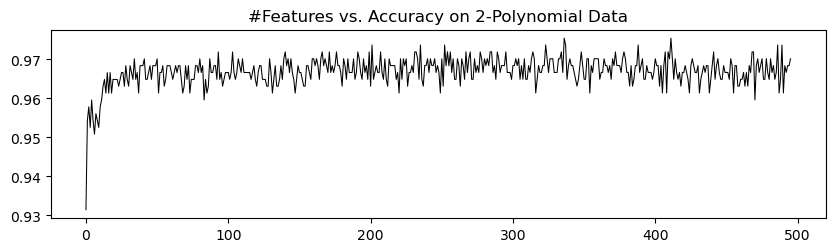

In [88]:
title = "#Features vs. Accuracy on 2-Polynomial Data"
(pd.Series(best_feat.grid_scores_)
     .plot(figsize=(10, 2.5), linewidth=0.75, title=title))
plt.savefig(f'img/(Ch07){title}.png')

## Exercises

The exercises below ask you to look for "continuous-like" results in discrete events, and then symmetrically to treat continuous or frequent events as measures of coarser time units.  Both of these modifications to create synthetic features are commonly useful and appropriate in real-world data sets.

### Intermittent Occurrences

This chapter discussed imposing regularity upon timestamp fields, but this exercise asks you to reverse that goal, in a way.  There are times when events are inherently erratic in occurrence.  For example, a Geiger counter measuring radiation produces a "click" (or other discrete signal) each time a threshold is reached for ionizing radiation being present.  Similarly, we could measure the timestamp when each new bud appears within a grove of trees; the frequency of occurrences would correspond in some overall way to the growth rate, but the individual events are stochastically distributed.  Other phenomena—for example, the Covid-19 pandemic (currently underway, at time of this writing), with new diagnoses on particular days within each geopolitical region—have similar discreet events that indirectly define an overall pattern.

An artificial data set is provided that contains events measured by any of five instruments over the one year interval covering 2020.  The recording of events occurs only at exact minutes, but that does not preclude multiple events occurring during the same minute.  In general, the typical event frequency for each instrument is less frequent than once per minute.  The five instruments are simply named as 'A' through 'E'.  You are free to imagine this data describing one of the phenomena mentioned above, or whatever other domain you wish.

The data set is available at:

> https://www.gnosis.cx/cleaning/events.sqlite

Records within the data set will resemble the following few.

timestamp           | instrument
--------------------|------------
2020-07-04 11:28:00 | A
2020-07-04 11:29:00 | B
2020-07-04 11:31:00 | C
2020-07-04 11:34:00 | D
2020-07-04 11:28:00 | A
2020-07-04 11:34:00 | A

Notice that the data do not necessarily occur in chronological order.  Moreover, the same timestamp may contain multiple events, either from the same or a different instrument.  For example, in the table, '2020-07-04 11:28:00' measured two events from instrument A, and '2020-07-04 11:34:00' measured one event from instrument A and another event from instrument D.  There are approximately one million events recorded in total.

Each instrument exhibits a different pattern in relation to time sequence.  Create however many synthetic features you feel are necessary to reasonably characterize the behaviors in numeric form.  However, *do* think of features as numbering in tens or hundreds, not in hundreds of thousands. Put these features into a tidy data frame that might be used for further statistical analysis or machine learning techniques.  This data frame will have columns corresponding to the synthetic features you have decided to utilize.

Attempt to characterize the behavior of each instrument in general terms, using prose descriptions, or perhaps using mathematical functions.  Be as specific as you feel the data warrants, but also describe the limitations or uncertainties of your characterization as well as possible.

### Characterizing Levels

In this exercise, use the same data set as in the prior exercise, which is available at:

> https://www.gnosis.cx/cleaning/events.sqlite

As described above, each of five instruments measures discrete events occurring at specific timestamps.  Events are discerned at one minute accuracy, and the time series covers calendar year 2020.  Some minutes have multiple events (from either the same or different instruments), and some have no events.

Your goal in this exercise is to characterize each day of the year according to whether it is 'low', 'medium', or 'high' in event frequency.  You should characterize this quantized level both per individual instrument, and for the day as a whole.  You should decide what quantization strategy is most appropriate both for the cummulative frequencies and the per-instrument frequencies.  Your choice of strategy is likely to depend upon the different distributions of events per each instrument.

You may assume that all five instruments measure something roughly commensurate in aggregating them.  For example, if these events are the detection of a new bud on a tree—per one example in the previous exercise—the different instruments might be measuring different groves (but not buds versus leaves versus fruits, for example).

If you feel that the quantization of low/medium/high is not well suited to one or more of the instrument event distributions, characterize what problem or limitation you feel applies, and try to think of an alternate approach to characterizing the instrument behavior.

## Denouement

> And this old world is a new world<br/>
> And a bold world<br/>
> For me<br/>–Nina Simone

**Topics**: Date/time fields; String fields; String Vectors; Decompositions; Quantization; One-Hot Encoding; Polynomial Features

This chapter looked at many approaches to *inventing new features*.  This stands in contrast to chapter 6 (*Value Imputation*) that was about *inventing data points*.  Both techniques are important in their own ways, but they do something conceptually different.  It often happens that the way we collect data or are provided it, does not represent the most meaningful content of that data, yet better representations lurk within what we have.

Three general themes were presented in the creation of synthetic features.  In one case, we sometimes have a single feature that, as represented, combines two or more basic features that can be easily pulled apart and represented separately.  Similarly, but moving in the other direction, sometimes a small number of components that are directly present may be better combined into a single feature.  A clear example for both of these moves is a datetime value that might be either several components such as year, month, hour, minute, or might be a single value.

As a second theme, we looked at the parameter space in which observations live as vectors.  As an abstract mathematical entity, the initial observations need not form the orthonormal basis (the dimensions) of an observation vector.  Often transforming the basis of the parameter space produces dimensions that are more useful for statistics and machine learning.  However, it is worth remembering that after such transformations, the synthetic features rarely have any human meaningful sense to them, but are exclusively numeric measures.

As a third theme, we looked at synthetic features that emerge from the interaction of an initial feature with either its domain of values or with other initial features.  Intuitively, there are quantities that are never directly measured: "heat index" is an interaction of summer temperature and humidity; "body mass index" is an interaction of human weight and height.  At times, the interactions are more informative than are those things we directly measure.  Using polynomial feature engineering we can explore the space of all such interactions, but with the pitfall of sometimes arriving at unworkably many features.  In that last circumstance, feature selection comes to our rescue.